# Restructured version of  initial development based on pylisa's apci_20_varying_workshop-based notebook

This notebook follows initial-dev-from-pylisa, but with code restructured into the module core.

The initial-dev-from-pylisa is based on apci_20_varying_workshop-based in pylisa, which was already a work in progress toward a refresh of some of the core aPCI functionality with connection to contemporary LISAinstrument and other tools.  It had already lost dependence on most of the pylisa code in favor of a new version inder development in the notebook.  This notebook brings that development here.

We are working toward a new simpler and better structured version of this which is suitable for generalizing to longer data sets.  The prior versions of this notebook are already very memory intensive and mixed up with the simulation processes and the TDI analysis. We hope to separate and distinguish these parts better, using code structures that facilitate throwing away large objects as soon as they are no longer needed. 

Note that the basic 6 channel input data at 4Hz sampling should be $6*4*8=192$ bytes per simulations second for about 16MB per simulation day.  The aPCI datamatrix, though may be hundreds of times larger!

## 0. Necessary installations

Installation of the LISA Simulation suite is required, just like in the workshop:

    pip install numpy scipy sympy h5py matplotlib xarray h5py scikit-learn
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/constants.git@latest
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/instrument.git@latest
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/gw-response.git@latest
    pip install pytdi
    pip install backgrounds

In [1]:
import importlib
#importlib.reload(pytdi)
import numpy as np
import copy
from scipy import signal, constants, interpolate
from matplotlib import pyplot as plt
import h5py
# Instrument
#from lisainstrument import Instrument
#from lisainstrument.containers import ForEachSC
#from lisainstrument.containers import ForEachMOSA
# TDI
#from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi.intervar import ETA_SET
from pytdi import Data
# PCI
#from pylisa import covariance, apci, plotting, sensitivity, eigen
from pcipy import plotting, pci_filter, channel_analysis 
from sklearn.decomposition import PCA
# FTT modules
import pyfftw
from pyfftw.interfaces.numpy_fft import fft, ifft
pyfftw.interfaces.cache.enable()
!free

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     1722912    11872472        1276     2315940    13874860
Swap:             0           0           0


In [2]:
# minimal stuff copied from pylisa/eigen for direct compatibility
# it is probably clearer to use np.einsum explicitly though
class eigen:
    def multiple_dot(a_mat, b_mat):
        """
        Perform the matrix multiplication of two list of matrices.

        Parameters
        ----------
        a : ndarray
            series of m x n matrices (array of size p x m x n)
        b : ndarray
            series of n x k matrices (array of size p x n x k)

        Returns
        -------
        c : ndarray
            array of size p x m x k containg the dot products of all matrices
            contained in a and b.


        """

        return np.einsum("ijk, ikl -> ijl", a_mat, b_mat)
    def multiple_dot_vect(a_mat, b_vect):
        """[summary]

        Parameters
        ----------
        a : ndarray
            series of m x n matrices (array of size p x m x n)
        b : ndarray
            series of n x k vectors (array of size p x n)

        Returns
        -------
        c : ndarray
            array of size p x m containg the dot products of all vectors
            contained in a and b.


        """

        return np.einsum("ijk, ik -> ij", a_mat, b_vect)


In [3]:
#minimal copied from pylisa apci aka apci_core
class apci:
    def build_data_matrix(p_list, nhalf=20, window='kaiser', beta=14):
        """
        Pre-process data to build a matrix of features of size n_features x n_data

        Parameters
        ----------
        p_list : list[ndarrays]
            list of channel data
        nhalf : int
            half-size of shift kernel
        beta : float
            window shape parameter

        Returns
        -------
        datamatrix : ndarray
            data matrix of size n_data x (2*nhalf+1)*nc

        """

        # Data sample size
        ns = p_list[0].shape[0]
        # Number of channels
        if type(p_list) == list:
            nc = len(p_list)
        else:
            nc = p_list.shape[0]
        # Time windowing
        if type(window) == str:
            if window == 'kaiser':
                window = np.kaiser(ns, beta)
            elif window == 'blackman':
                window = np.blackman(ns)
        elif type(window) == np.ndarray:
            pass
        else:
            raise TypeError("Window should be string or array")

        datamatrix = np.hstack([np.array([apci_data.construct_shifted_series(None, p, ishift, window=window) 
                                          for p in p_list]).T for ishift in np.arange(-nhalf, nhalf+1)])

        return datamatrix
    
    def compute_equivalent_vector(freqs, b_mat, v_pci, nhalf, i, psdi=None, fs=1.0):
        """Compute a vector whose squared modulus 
        will allow one to compute PSDs.

        Parameters
        ----------
        freqs : ndarray
            Frequency array [Hz], size n_freq
        b_mat : ndarray
            transfer matrix from the noise array to single-link measurements
            size n_freq x n_channels x n_noises
        v_pci : list[ndarray]
            list of PCI eigenvectors
        nhalf : int
            half stencil size
        i : int
            index of the equivalent vector (as many as laser noise terms)
        psdi : ndarray
            psd of noise i
        fs : float
            Sampling frequency [Hz]
        """

        # Try another way of computing the residual laser noise PSD
        x1 = np.zeros((b_mat.shape[0], b_mat.shape[2]))
        if psdi is None:
            x1[:, i] = 1.0
        else:
            x1[:, i] = np.sqrt(psdi)
        # Transform x1 as laser noise
        yi = eigen.multiple_dot_vect(b_mat, x1)
        # Transform y1 into the data matrix
        datamatrix = []
        for ishift in np.arange(-nhalf, nhalf+1):
            for p in yi.T:
                pshift = p * np.exp(-2j * np.pi * freqs * ishift / fs)
                datamatrix.append(pshift)
        mi = np.column_stack(datamatrix)

        # Apply PCI transform
        ei = np.array(v_pci).dot(mi.T).T

        return ei



## 1. Read in LISA Instrument simulation

### 1.1 Parameters

### 1.2 Simulate or retrieve single-link measurements

You can simulate the single-link data directly from with the cell below, by uncommenting the last code lines.
However, this is not recommended as this is memory and CPU-consumming. You can use the following scripts instead:

    python noise_simulation.py /work/SC/lisa/baghiq/sgwb/simulations
    python signal_simulation.py /work/SC/lisa/baghiq/sgwb/simulations
    
You can find these two scripts in the /tests directory. They will respectively generate the noise and signal data.

In [4]:
# Choose orbit file
# orbits = "/Users/qb265383/Codes/instrument/tests/keplerian-orbits.h5"
# orbits = "/pbs/home/q/qbaghi/codes/instrument/tests/keplerian-orbits.h5"
# orbits = "/work/SC/lisa/baghiq/orbits/keplerian-orbits.h5"
datadir = "/data/jgbaker/software/pylisa/data/"
orbits = datadir+"keplerian-orbits.h5"
workdir = datadir+"/simulations/"
dtpath = "2024-04-10_18h14_"

In [5]:

skip = 300

def build_data_vector(data_noise, skip=200, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full


In [6]:
# If we use a file
simpath = workdir + dtpath + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# load data
data_noise = Data.from_instrument(simpath)
y_full = build_data_vector(data_noise, skip=200)

# Get secondary noises
# sec_file = "/work/SC/lisa/baghiq/pci/simulations/23-05-2022_10h10_noise_sec_4Hz.h5"
# sec_file = datadir+'/simulations/2024-29-07_18h06_noise_sec_4Hz.h5'

secpath = workdir + dtpath + 'noise_sec_4Hz.h5'

data_sec = Data.from_instrument(simpath)
    
y_sec = build_data_vector(data_sec, skip=skip, dtype=np.float64)

#######
fs = data_noise.fs
central_freq = sim.attrs['central_freq']
dt = sim.attrs['dt']
n_data = sim.attrs['size']

You are using a measurement file in a version that might not be fully supported
You are using a measurement file in a version that might not be fully supported


## 2. Applying INREP TDI pipeline

### 2.2 Compute the TDI variables (or retrieve them from file)

You can compute the TDI variables using the cells below, or use the generation scripts in Section 1.2.

In [7]:
tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
tdipath2 = workdir +  dtpath + 'noise_tdi2_4Hz.h5'
# open hdf5 TDI file
tdi1 = h5py.File(tdipath1, 'r')
tdi2 = h5py.File(tdipath2, 'r')

x2_noise = tdi2['x2'][()] / central_freq
y2_noise = tdi2['y2'][()] / central_freq
z2_noise = tdi2['z2'][()] / central_freq

## 3. aPCI analysis

In [8]:
# TDI2 fractional delay Lagrange interpolating polynomials are of order 31=1+15*2
# Overall TDI delays are up to 8x single link delay = 8.34 s * 4 Hz * 8 = about 267 sample
# Add 15 on each end: 267 + 2*15 = 297   
# TDI2 overall stencil is then about 297 samples
# aPCI overall stencil width is 1 + nhalf*2
nhalf = 45
# Us 12 hours data
#ns = int(12 * 3600 * fs)
ns = int(3 * 3600 * fs)
window = np.ones(ns)

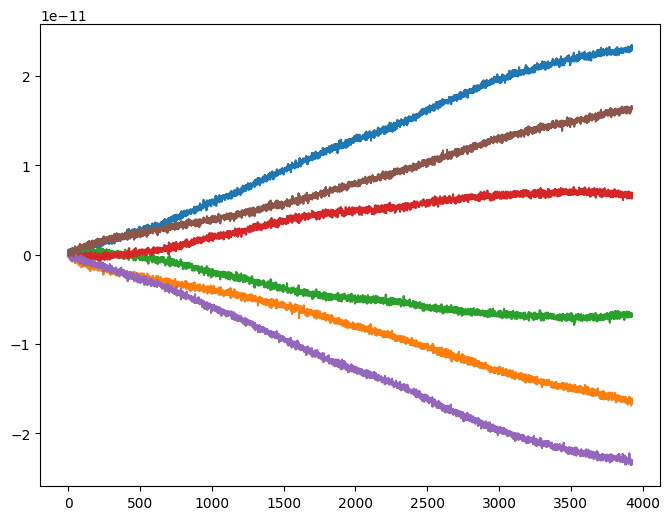

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     2539488    11057220        1276     2314616    13058268
Swap:             0           0           0


In [9]:
# Check time series
maxshow=4000
ev=ns//maxshow+1
_, axes = plt.subplots(1, 1, figsize=(8, 6))
for ich in range(len(y_full.T)):
    axes.plot(y_full[skip:skip+ns:ev, ich])
plt.show()
!free

### 3.1 Define PCI 2.0 data matrix

In [10]:
importlib.reload(pci_filter)
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10)            
            for q in range(3)]
#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


shape in build datamatrix (1, 43200, 546)
(43200, 546)
(43200, 546)
diagonality test
[[ 1.00000000e+00 -1.66533454e-16 -7.28583860e-17 -4.16333634e-17
   1.11022302e-16  3.26128013e-16  5.72458747e-17 -8.87311058e-16
  -6.59194921e-17  7.62844649e-16]
 [-1.66533454e-16  1.00000000e+00  1.20476545e-15 -4.99600361e-16
   7.63278329e-17 -5.20417043e-18  9.71445147e-17 -2.42861287e-16
  -8.32667268e-17  1.17961196e-16]
 [-7.28583860e-17  1.20476545e-15  1.00000000e+00  1.02348685e-15
   1.19695920e-16 -4.99600361e-16  0.00000000e+00  3.46944695e-18
   2.22044605e-16  1.09287579e-16]
 [-4.16333634e-17 -4.99600361e-16  1.02348685e-15  1.00000000e+00
  -3.40005801e-16  3.60822483e-16 -3.05311332e-16 -2.49800181e-16
   9.71445147e-17  8.67361738e-17]
 [ 1.11022302e-16  7.63278329e-17  1.19695920e-16 -3.40005801e-16
   1.00000000e+00  6.66133815e-16  1.27068495e-16 -4.57966998e-16
  -3.81639165e-16 -8.88178420e-16]
 [ 3.26128013e-16 -5.20417043e-18 -4.99600361e-16  3.60822483e-16
   6.66133815e

shape in build datamatrix (3, 43200, 546)
unstacked data mtrix shape (43200, 3, 546)
comps shape (4, 1638)
comps reshaped (4, 3, 546)
(3, 4, 43200)
mean: 1.8044049098342207e-21
variance:  1.430840097763286e-42
mean: -3.35114887621925e-21
variance:  3.736989248722469e-42
mean: 1.2711739454524001e-20
variance:  4.8282863548991325e-42
mean: 2.4928454942934924e-22
variance:  6.045682756071241e-42


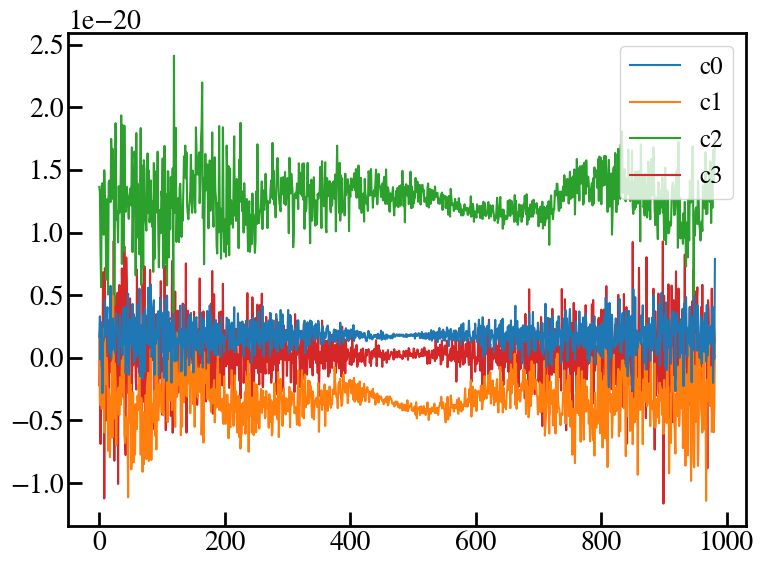

shape in build datamatrix (3, 43200, 546)
unstacked data mtrix shape (43200, 3, 546)
comps shape (4, 1638)
comps reshaped (4, 3, 546)


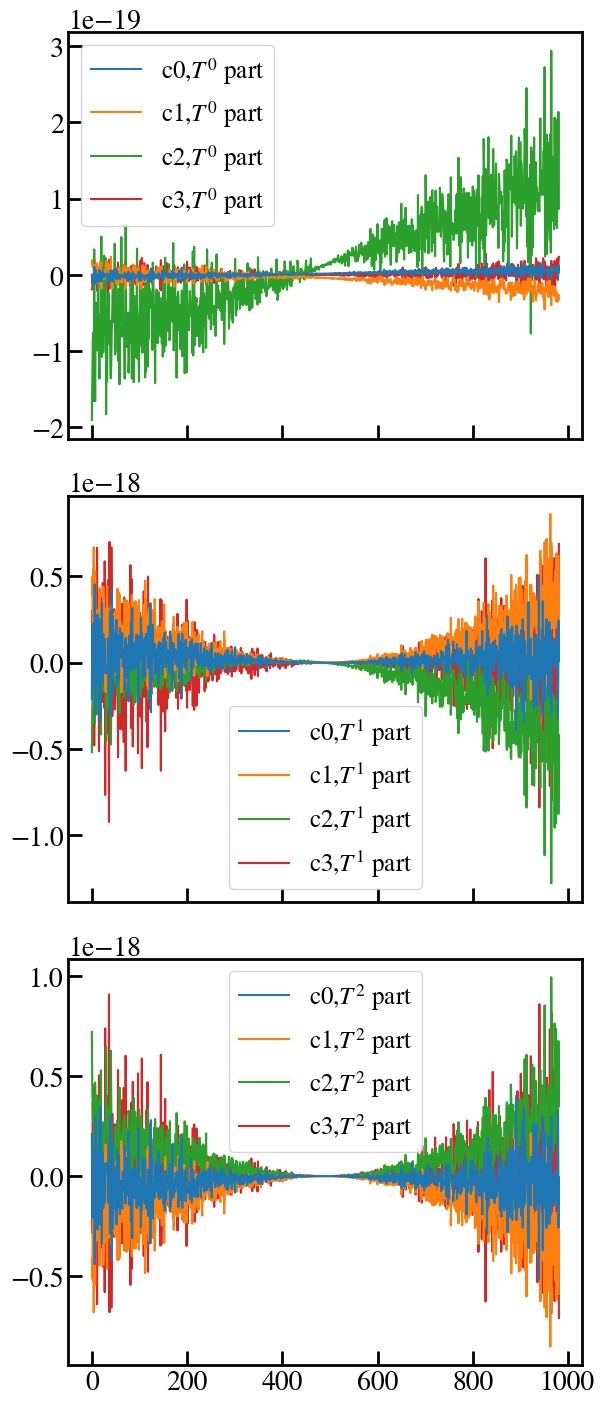

mean: 2.4928454942934924e-22
check variance (intrinsic):  6.045682756071241e-42 6.045682752103428e-42
mean: 1.2711739454524001e-20
check variance (intrinsic):  4.8282863548991325e-42 4.8282863561483976e-42
mean: -3.35114887621925e-21
check variance (intrinsic):  3.736989248722469e-42 3.736989222009903e-42
mean: 1.8044049098342207e-21
check variance (intrinsic):  1.430840097763286e-42 1.4308400970815198e-42


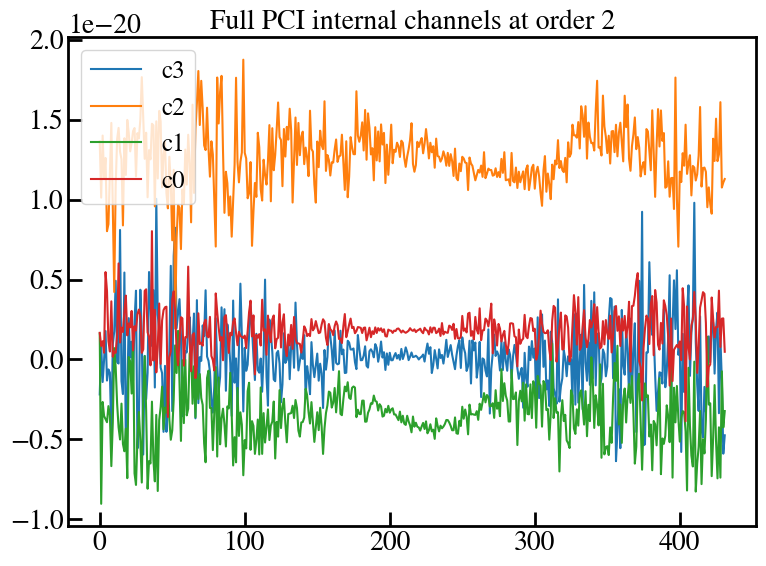

mean: 2.4928454763904586e-22
check variance (extrinsic):  6.045682761713777e-42 6.045682752103428e-42
mean: 1.2711739494618295e-20
check variance (extrinsic):  4.8282862266113185e-42 4.8282863561483976e-42
mean: -3.3511488749010677e-21
check variance (extrinsic):  3.7369893093647287e-42 3.736989222009903e-42
mean: 1.8044049096075805e-21
check variance (extrinsic):  1.4308400941314466e-42 1.4308400970815198e-42


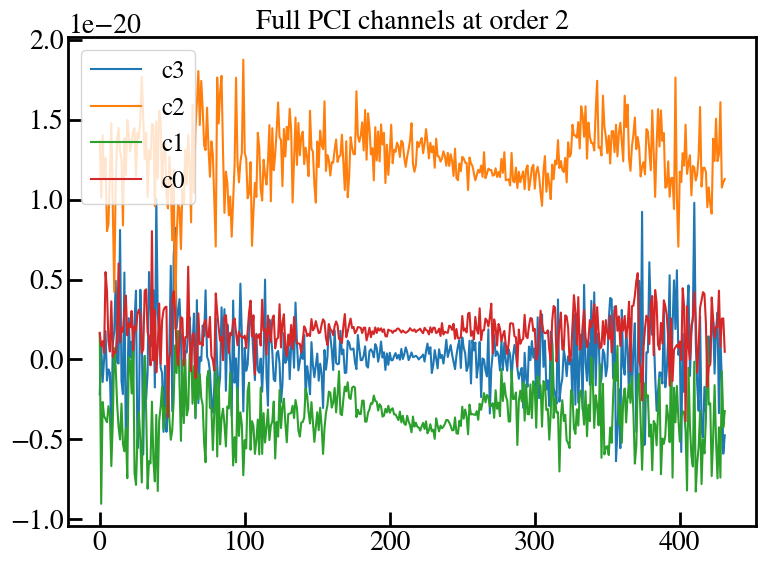

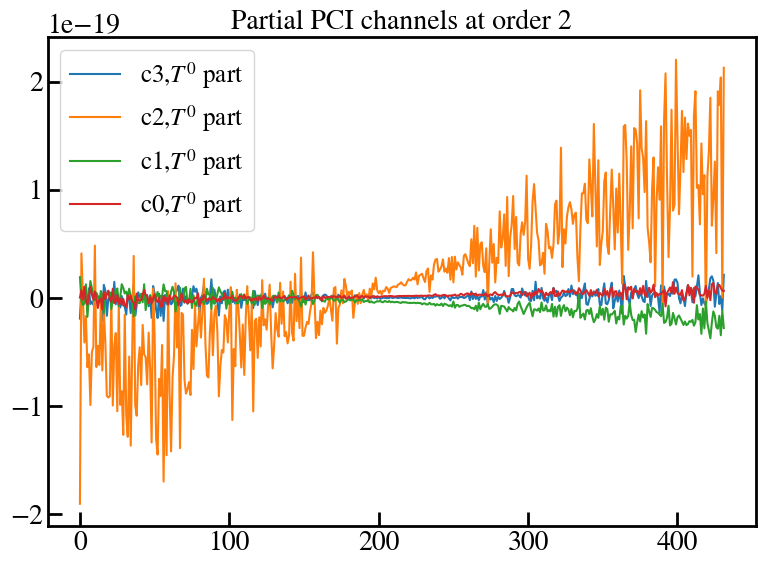

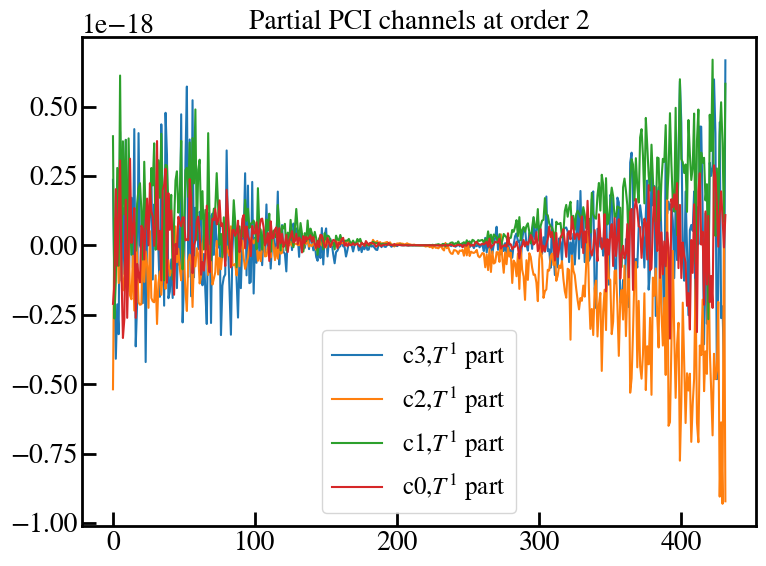

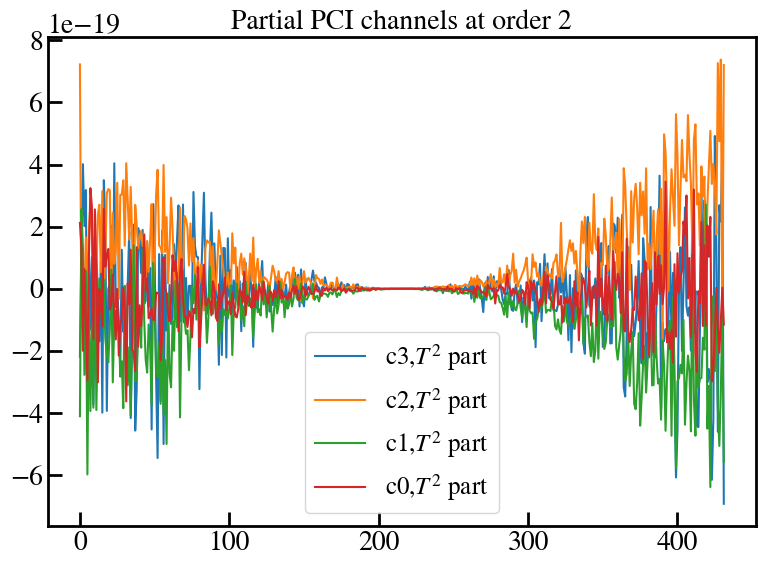

In [32]:
importlib.reload(channel_analysis)
order=2
ev=100
x=np.array(pca_list[order].apply_for_channels_split_orders(y_full[:ns+2*nhalf, :].T, n_channels=4))
print(x.shape)
channel_analysis.stationarity_plots(pca_list[order],y_full[:ns+2*nhalf, :].T,nchan=4,split_orders=True)
for ich in range(x.shape[1]-1,-1,-1):
    xch=pca_list[order].channels[-(ich+1)]
    plt.plot(xch[::ev],label='c'+str(ich))
    plt.title("Full PCI internal channels at order "+str(order))
    #check var:
    chmean=np.mean(xch)
    print('mean:',chmean)
    print('check variance (intrinsic): ',sum((xch-chmean)**2)/(len(xch)-1),pca_list[order].explained_variance[-(ich+1)])
plt.legend()
plt.show()
for ich in range(x.shape[1]-1,-1,-1):
    xch=np.sum(x,axis=0)[-(ich+1)]
    plt.plot(xch[::ev],label='c'+str(ich))
    plt.title("Full PCI channels at order "+str(order))
    chmean=np.mean(xch)
    print('mean:',chmean)
    print('check variance (extrinsic): ',sum((xch-chmean)**2)/(len(xch)-1),pca_list[order].explained_variance[-(ich+1)])
plt.legend()
plt.show()
for iord in range(order+1):
    for ich in range(x.shape[1]-1,-1,-1):
        plt.plot(x[iord,-(ich+1)][::ev],label='c'+str(ich)+',$T^'+str(iord)+'$ part')
        plt.title("Partial PCI channels at order "+str(order))
    plt.legend()
    plt.show()


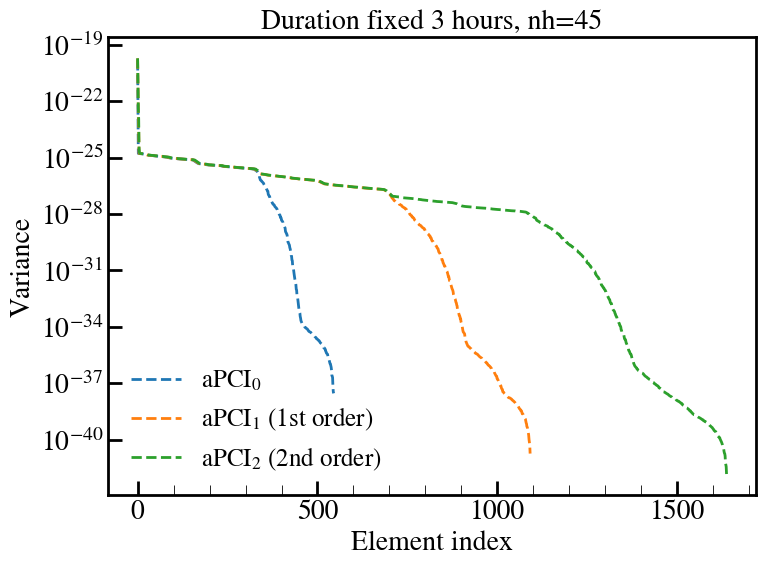

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     2650936    10945768        1276     2314620    12946820
Swap:             0           0           0


In [12]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

ax1.plot(pca_list[0].explained_variance_, 
            linestyle='dashed',
            label=r'aPCI$_0$',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[1].explained_variance_, 
            linestyle='dashed',
            label=r'aPCI$_1$ (1st order)',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[2].explained_variance_,
            linestyle='dashed',
            label=r'aPCI$_2$ (2nd order)',
            linewidth=2,
            rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Element index", fontsize=20)
ax1.set_ylabel("Variance", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='lower left', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free

In [13]:
# PCI transformation vector
n_channels = 6
e_pci_list = []


for j in range(3):        
    e_pci_list.append(pca_list[j].e_pci(n_channels))


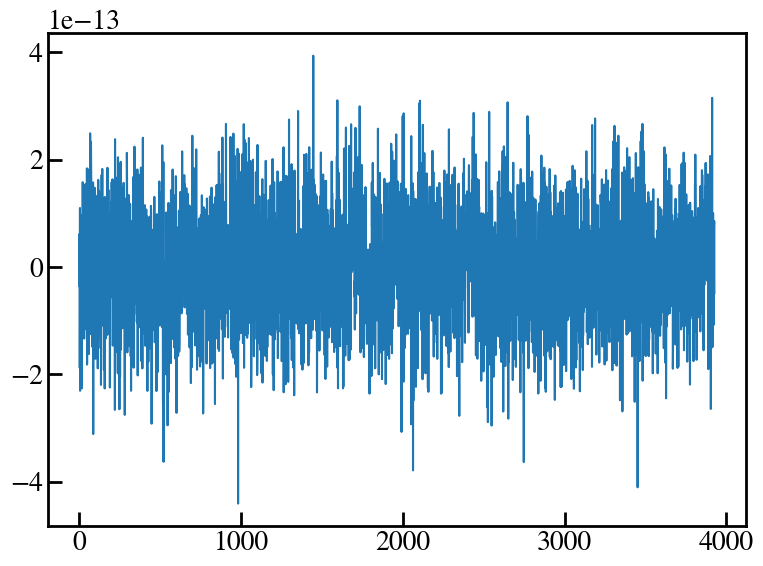

In [14]:
ev=ns//maxshow+1
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.plot(x2_noise[skip:skip+ns:ev])
plt.show()

In [15]:
# Transform PCI variables to Fourier domain
wd = np.blackman(ns)
# wd = signal.windows.nuttall(e_pci_list[0].shape[1])
k22 = np.sum((wd*window)**2)
e_pci_list_fft = [fft(e_pci * wd[np.newaxis, :], axis=1) for e_pci in e_pci_list]
p_pci_list = [np.abs(e_pci_fft) * np.sqrt(2 / (k22 * fs)) for e_pci_fft in e_pci_list_fft]
f = np.fft.fftfreq(e_pci_list[0].shape[1]) * fs
ipos = np.where(f > 0)[0]
# Transform TDI variables to Fourier domain
k2 = np.sum(wd**2)
x2_fft = fft(wd * x2_noise[skip:skip+ns]) * np.sqrt(2/(fs*k2))

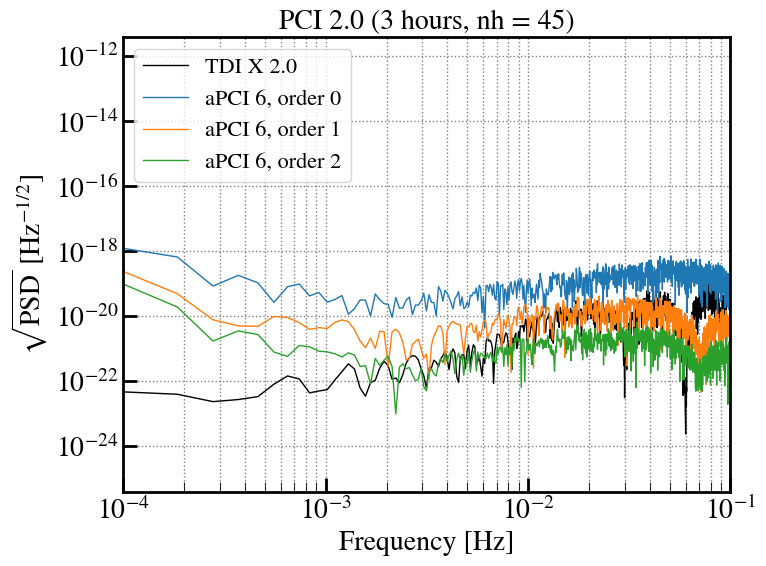

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     2696396    10900204        1276     2314724    12901332
Swap:             0           0           0


In [16]:
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 spectrum
axes.loglog(f[ipos], np.abs(x2_fft[ipos]), 
            label='TDI X 2.0', 
            color='black', linewidth=1)

# aPCI 2.0 spectra
jstart = 5
for j in range(jstart, n_channels):  

    axes.loglog(f[ipos], np.abs(p_pci_list[0][j, ipos]), 
                label='aPCI ' + str(j+1) + ', order 0', 
                # color=colors[j], 
                linewidth=1)

    axes.loglog(f[ipos], np.abs(p_pci_list[1][j, ipos]), 
                label='aPCI ' + str(j+1) + ', order 1', 
                # color=colors[j], 
                linewidth=1)
for j in range(jstart, n_channels):  
    axes.loglog(f[ipos], np.abs(p_pci_list[2][j, ipos]), 
                label='aPCI ' + str(j+1) + ', order 2', 
                # color=colors[j], 
                linewidth=1)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz^{-1/2}}$]")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1e-1])
plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
plt.show()
!free

## 4. Modeled Response to gravitational waves

In [17]:
import healpy as hp
from backgrounds import StochasticPointSourceResponse, StochasticBackgroundResponse
from pylisa.simulator import lisanoise
#from backgrounds.utils import CovarianceInterpolator

In [18]:
def compute_welch_matrix(ydata, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat



In [19]:
##This is a mess of stuff that we've copied from "apci_20_varying_analytic_model_4Hz" 
def transform_covariance(tf, cov):
    return eigen.multiple_dot(tf, eigen.multiple_dot(cov, np.swapaxes(tf, 1, 2).conj()))

def process_pixels(pixels):
    # Initialize SGWB spectrum matrix
    cov_gw_1_00 = np.zeros((n_freqs, 6, 6), dtype=complex)
    # We need to add the correlation matrices for each pixel
    for pixel in pixels:
        gw_theta, gw_phi = hp.pix2ang(hp_nside, pixel)
        gw_beta, gw_lambda = np.pi / 2 - gw_theta, gw_phi
        source = StochasticPointSourceResponse(
            gw_beta, gw_lambda, orbits=orbits)
        # Compute pixel correlations matrix
        gp, gc = source.compute_kernel(
            resp.LINKS, freqs_a, np.array([t0]), deriv=0, t_shift=False, approx=False)
        del source
        # Compute cross-PSD model
        gw_mat = np.zeros((n_freqs, 6, 2), dtype=complex)
        # Plus polarization
        gw_mat[:, :, 0] = gp[convert, :].T
        # Cross polarization
        gw_mat[:, :, 1] = gc[convert, :].T
        del gp, gc
        # Compute GW equivalent vector
        e_vect_1_00 = [apci.compute_equivalent_vector(
        freqs_a, gw_mat, v_pci_mat_1[:, 0:q], nhalf, i, fs=fs) 
                       for i in range(gw_mat.shape[-1])]
        # Add contribution of pixel to PSD
        cov_gw = sum([eigen.multiple_dot(e[:, :, np.newaxis], e[:, np.newaxis, :].conj())
                            for e in e_vect_1_00])
        del e_vect_1_00
        cov_gw_1_00 += cov_gw
        # Orthogonalized version
        # cov_gw_1_00_ortho += transform_covariance(vh_pci_n[:, 0:3, :], cov_gw)
        if pixel % 50 == 0:
            print(pixel,'/',pixels[-1])
        del cov_gw

    return cov_gw_1_00

nperseg = 2**16
#nperseg = 2000
kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

recompute = True
orthogonalize = False
hp_nside=8
npix=hp.nside2npix(hp_nside)
m = np.ones(npix)
resp = StochasticBackgroundResponse(skymap=m, orbits=orbits)
print('resp.LINKS',resp.LINKS)
t0 = ns * dt / 2
convert = np.array([0, 1, 2, 3, 5, 4])

kwargs_mod=copy.deepcopy(kwargs)
#kwargs_mod["fs"]=freqs_a

# Representatitive frequencies
f1 = 1e-4
f2 = 1.0
nf = 1000
freqs_a = f1 * (f2/f1)**(np.arange(0, nf)/(nf-1))
   
## probably this orthogonalize    ###This operation is added to pci_data 
if orthogonalize:    
    # Compute 1st order PCI secondary noises PSD from 00 covariance component
    nm = lisanoise.NoiseModel(fs)
    instrument_psd = nm.other_noise_model
    s_n = instrument_psd(freqs_a)
    n_components = 6
    n_mat = np.array([np.eye(6) for freq in freqs_a])
    v_pci_mat_1 = pca_list[1].components_[-n_components:, :]
    q = 6 * (2*nhalf+1) # Size of the data matrix side

    # Compute PCI equivalent vector for the noise
    e_vect_1_00 = [apci.compute_equivalent_vector(freqs_a, n_mat, v_pci_mat_1[:, 0:q], nhalf, i, fs=fs) 
                   for i in range(6)]
    # Compute secondary noise PCI covarinace
    cov_n_1_00 = sum([eigen.multiple_dot(e[:, :, np.newaxis], np.conj(e[:, np.newaxis, :]))
                                         for e in e_vect_1_00])
    cov_n_1_00 *= s_n[:, np.newaxis, np.newaxis]
    # Compute eigenvalues
    u_pci_n, w_pci_n, vh_pci_n = np.linalg.svd(cov_n_1_00)

if recompute:
    n_freqs = freqs_a.shape[0]
    # Compute 1st order PCI secondary noises PSD from 00 covariance component
    n_components = 6
    v_pci_mat_1 = pca_list[1].components_[-n_components:, :]
    q = 6 * (2*nhalf+1) # Size of the data matrix side

    def process_pixels(pixels):
        # Initialize SGWB spectrum matrix
        cov_gw_1_00 = np.zeros((n_freqs, 6, 6), dtype=complex)
        # We need to add the correlation matrices for each pixel
        for pixel in pixels:
            gw_theta, gw_phi = hp.pix2ang(resp.nside, pixel)
            gw_beta, gw_lambda = np.pi / 2 - gw_theta, gw_phi
            source = StochasticPointSourceResponse(
                gw_beta, gw_lambda, orbits=resp.orbits_path)
            # Compute pixel correlations
            ## note: This may realize (the square of) eq 24 of https://doi.org/10.1002/andp.202200447 (verify with Quentin)
            gp, gc = source.compute_kernel(
                resp.LINKS, freqs_a, np.array([t0]), deriv=0, t_shift=False, approx=False)
            del source
            # Compute cross-PSD model
            gw_mat = np.zeros((n_freqs, 6, 2), dtype=complex)
            # Plus polarization
            gw_mat[:, :, 0] = gp[convert, :].T
            # Cross polarization
            gw_mat[:, :, 1] = gc[convert, :].T
            del gp, gc
            # Compute GW equivalent vector
            e_vect_1_00 = [apci.compute_equivalent_vector(
                freqs_a, gw_mat, v_pci_mat_1[:, 0:q], nhalf, i, fs=fs) 
                           for i in range(gw_mat.shape[-1])]
            # Add contribution of pixel to PSD
            cov_gw = sum([eigen.multiple_dot(e[:, :, np.newaxis], e[:, np.newaxis, :].conj())
                                for e in e_vect_1_00])
            del e_vect_1_00
            cov_gw_1_00 += cov_gw
            # Orthogonalized version
            # cov_gw_1_00_ortho += transform_covariance(vh_pci_n[:, 0:3, :], cov_gw)
            if pixel % 50 == 0:
                print(pixel,'/',pixels[-1])
            del cov_gw

        return cov_gw_1_00


    pixels = np.arange(resp.npix)
    # n_patches = 16
    # patch_size = int(resp.npix / n_patches)
    # results = Parallel(n_jobs=16, backend='multiprocessing', verbose=1)\
    #     (delayed(process_pixels)(pixels[i*patch_size:(i+1)*patch_size]) for i in range(n_patches))
    # cov_gw_1_00 = 0.5 * sum(results)

    cov_gw_1_00 = process_pixels(pixels)
    cov_gw_1_00 *= 0.5
    np.save("cov_gw_1_00.npy", cov_gw_1_00)
    if orthogonalize:
        cov_gw_1_00_ortho = transform_covariance(vh_pci_n[:, 0:3, :], cov_gw_1_00)    
        np.save("cov_gw_1_00_ortho.npy", cov_gw_1_00_ortho)
    
else:
    cov_gw_1_00 = np.load("cov_gw_1_00.npy")
    if orthogonalize: cov_gw_1_00_ortho = np.load("cov_gw_1_00_ortho.npy")


#Application to laser residuals in apci_20_varying_analytic_model_4Hz.ipynb
##  Compute the pci channel noise contribs
#e_pci_p1 = np.array([v.dot(datamatrix_laser_list[1].astype(np.float64).T) for v in v_pci_full]).T
##  Compute orthogonalizer based on the analytical secondary noise model.  (See above around line 70, this block)

#u_pci_n_f, w_pci_n_f, vh_pci_n_f = np.linalg.svd(cov_n_1_00_f)
## Compute how laser noise transforms into orthogonal PCI variables
#e_pci_p1_fft = fft(e_pci_p1 * wd[:, np.newaxis], axis=0) * np.sqrt(2 / (fs*k2))
#e_pci_p1_fft_ortho = eigen.multiple_dot_vect(vh_pci_n_f, e_pci_p1_fft[0:n_fft+2])
## Smooth the orthogonalized noise PCI vars
'''
smoothper_pci_p_ortho = []
data_fft_full = symmetrize(e_pci_p1_fft_ortho[:], n_psd)
df_min = 7e-5
df_max = 2e-3
f_min = 1e-5
f_max = 1.001
f_grid = frequency_grid(df_min, df_max, f_min, f_max)
# f_grid = freqs_a[:]
for j in range(3):
    y_h = np.abs(data_fft_full[:, j])**2
    freqs_h, p_h, segment_sizes = smooth(y_h, fs, f_grid)
    smoothper_pci_p_ortho.append(p_h)
'''
## Separately compute an interpolating function for the orthogonalized GW response, based on above part of this block
#cov_pci_gw_funcs = [interpolate.interp1d(freqs_a, cov_gw_1_00_ortho[:, i, i].real, kind='cubic', fill_value='extrapolate') for i in range(3)]
## Ratio give the sensitivity
#sens_pci1_emp_laser_welch = 1 / sum([cov_pci_gw_funcs[i](freqs_h)/np.abs(smoothper_pci_p_ortho[i]) for i in range(3)])



resp.LINKS [12, 23, 31, 13, 32, 21]
0 / 767
50 / 767
100 / 767
150 / 767
200 / 767
250 / 767
300 / 767
350 / 767
400 / 767
450 / 767
500 / 767
550 / 767
600 / 767
650 / 767
700 / 767
750 / 767


'\nsmoothper_pci_p_ortho = []\ndata_fft_full = symmetrize(e_pci_p1_fft_ortho[:], n_psd)\ndf_min = 7e-5\ndf_max = 2e-3\nf_min = 1e-5\nf_max = 1.001\nf_grid = frequency_grid(df_min, df_max, f_min, f_max)\n# f_grid = freqs_a[:]\nfor j in range(3):\n    y_h = np.abs(data_fft_full[:, j])**2\n    freqs_h, p_h, segment_sizes = smooth(y_h, fs, f_grid)\n    smoothper_pci_p_ortho.append(p_h)\n'

In [20]:
##Trying to organize a bunch of the above hodgepodge

class psd_sensitivity:
    '''
    This is development of codes and data for computing sensitivity curves based on an analytic model 
    for the secondary noise psd on the link channels based on what is applied in 
    apci_20_varying_analytic_model_4Hz.ipynb
    
    So far it is kind of just a collection of stuff that appears in that notebook
    
    '''
    
    def __init__(self, orbits_path, fs, hp_nside=8, tref=0):
        
        self.n_channels=n_channels
        self.orbits_path=orbits_path  ##It would be better to get past having to reference by file path
        self.fs = fs
        
        #Compute the pixels for the analysis:
        #  Might want an option where we use a single point instead of all sky
        self.nside=hp_nside
        self.npix=hp.nside2npix(hp_nside)
        self.m = np.ones(npix)
        self.resp = StochasticBackgroundResponse(skymap=m, orbits=orbits)  ##not sure we need this        
        self.LINKS =  [12, 23, 31, 13, 32, 21] ##=resp.LINKS
        pixels=[]
        for pixel in np.arange(self.npix):
            gw_theta, gw_phi = hp.pix2ang(self.nside, pixel)
            gw_beta, gw_lambda = np.pi / 2 - gw_theta, gw_phi
            pixels.append([gw_beta,gw_lambda])
        self.pixels=pixels

        nperseg = 2**16
        #nperseg = 2000
        kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}        
        #kwargs_mod["fs"]=freqs_a
        self.kwargs=kwargs    

        # Representatitive frequencies
        f1 = 1e-4
        f2 = 1.0
        nf = 1000
        self.freqs_a = f1 * (f2/f1)**(np.arange(0, nf)/(nf-1))
            
    def compute_pci_sensitivity(self, apci_obj, n_channels=None, y_noise_data=None, plots_label=None, plotdens=1000):
        '''
        Compute sensitivity for the specified aPCI construction.
        
        Required args:
          apci_object:     apci_data    Instance providing the aPCI construction
        
        Optional args:
          n_channels:      int          The dimension of aPCI subspace to apply for the analysis
          y_noise_data:    na.array     The single link noise data stream set to apply for the sensitivity calculation 
          
        This calculation applies an analytic treatment of the gravitational wave response with a realized noise
        data stream to compute the contribution to GW sensitivity curve for the supplied noise data.  The argument
        n_channels more allows restriction to a subset of the available aPCI channels present in the apci_data 
        object, otherwise all are used.  The y_noise_data arg provides the data to treat, otherwise the calculation
        is applied to the original data provided for the aPCI development.  This version of the calculation is
        realized by first orthogonalizing, then combining the orthogonal output channel sensitivities.
        
        '''
        #Following the  application to laser residuals in apci_20_varying_analytic_model_4Hz.ipynb
        ##  Compute the pci channel noise contribs
        if y_noise_data is None:
            e_pci = apci_obj.e_pci(n_channels)
        else:
            e_pci = apci_obj.apply_for_channels(y_noise_data, n_channels)
        print('y_noise_data shape', np.shape(y_noise_data))
        print('e_pci shape',np.shape(e_pci))
        
        kwargs= copy.deepcopy(self.kwargs)

        #The original approach from apci_20_varying_analytic... used an orthogonalization 
        #based on an analytic model for the secondary noises
        '''
        ##  Compute orthogonalizer based on the analytical secondary noise model.  (See above around line 70, this block)
        #f = np.fft.fftfreq(e_pci_list[0].shape[1]) * fs
        #n_psd = len(f)
        #n_fft = int((n_psd-1)/2)
        # Secondary noise design matrix
        #n_mat_f = np.array([np.eye(6) for fr in f[0:n_fft+2]])
        # Compute PCI equivalent vector for the noise
        #e_vect_1_00_f = [apci.compute_equivalent_vector(f[0:n_fft+2], n_mat_f, v_pci_mat_1[:, 0:q], nhalf, i, fs=fs) 
        #       for i in range(6)]
        # Compute secondary noise PCI covariance
        #cov_n_1_00_f = sum([eigen.multiple_dot(e[:, :, np.newaxis], np.conj(e[:, np.newaxis, :]))
        #                               for e in e_vect_1_00_f])
        #f_pos = np.hstack([[f[1]], f[1:n_fft+2]])
        #cov_n_1_00_f *= instrument_psd(f_pos)[:, np.newaxis, np.newaxis]
        #u_pci_n_f, w_pci_n_f, vh_pci_n_f = np.linalg.svd(cov_n_1_00_f)
        '''
        ##Why not a data-based orthogonalization option?  In fact the original channels were already orthogonal from the PCA.
        ##It is possible that we are computing the sensitivity for a distinct data-set though.
        ##If y_noise_data was not provided, then we shouldn't even need to re-orthogonalize the data.
        
        #First, let's compute the channel FFTs        ?
        e_pci_zero_mean=(e_pci.T-e_pci.mean(axis=1).T).T
        e_pci_f = fft(e_pci, axis=1)##Do we need some normalization here?
        f = np.fft.fftfreq(e_pci.shape[1]) * fs
        n_psd = len(f)
        n_fft = int((n_psd-1)/2)
        #Next the channel covariances (Welch matrix):
        #cov_n = sum([eigen.multiple_dot(e[:, :, np.newaxis], np.conj(e[:, np.newaxis, :]))
        #                               for e in e_pci_f])
        print('e_pci_f shape',np.shape(e_pci_f))
        freqs, p_wmat = compute_welch_matrix(e_pci.T, **kwargs)
        
        ##Diagnostics and exploration:
        '''
        For data-based orthogonalization: We note that the PCI channels should be orthogonal in the time
        domain, in terms of sample covariances.  The is not identical to the statistical covariance, though
        they should be equal in an ideal long-data limit for stationary noise.  Statistically stationary 
        diagonal covariance (among channels) in the time-domain does imply statistical diagonality among 
        channels in the Fourier domain as well. For imperfectly stationary, and finite-length data, though
        with strongly colored noise, it is not clear what to expect. We can try to better understand these 
        issues by looking at some diagnostics here.
        
        Investigation of the temporal covariance indicates that the nominal PCI channels are not approximately
        stationary, ut there covariance varies significantly across the data window.  We can try to model this
        by a stationary process, together with nonstationarity in the explicit time contributions in the data 
        matrix
        
        
        For a short window W, of len p, expect:
        <C_a.T W C_b> \sim sum_{jk} t(W)^{j+k} < Va^(j).T X.T W X Vb^{k}>
        where
        t(W) = Tr(T W)/p
        
        if may also suppose that
        < Va^(j).T X.T W X Vb^{k} > \sim p/n Va^(j).T X.T X Vb^{k}
        
        with H = (X, T X, T^2 X,... ) to what ever order
        
        Then we would predict that 
        
        '''
        
        ##Temporal variance and correlation
        if plots_label is not None:
            #we compute channel covariance in batches of size nbatch
            nchan=len(e_pci)
            nplot=nchan
            print('plotting',nplot,'of',nchan,'channels')
            #trim the data to a multiple of nbatch
            nbatch=10000
            ndata=len(e_pci.T)
            ntrim=(ndata//nbatch)*nbatch
            binned=e_pci[:,:ntrim].reshape(nchan,-1,nbatch)
            if True:
                print("subtracting bin means!")
                binned=(binned.T-binned.mean(axis=2).T).T
            #print(binned.shape)
            print(ntrim//nbatch,'batches of size',nbatch)
            #print(binned[0,0:2])
            
            
            ev=ntrim//nbatch//plotdens+1
            title='Channel stdevs for '+plots_label
            plotting.plotconfig(lbsize=18, lgsize=16)
            _, axes = plt.subplots(1, 1, figsize=(8, 6))
            stdevs=np.sqrt(np.mean(binned**2,axis=2))
            for j in range(nplot):
                jj=nchan-1-j
                print('stdevs shape',stdevs.shape,'ev',ev)
                print(stdevs[jj,::ev].shape)
                axes.semilogy(stdevs[jj,::ev], marker='.',linewidth=1, label=r'$\mathrm{ch}$[' + str(j+1) + ']')
            axes.legend(loc='upper left', ncol=2)
            axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
            axes.set_xlabel("sample")
            axes.set_ylabel(r"stdev")
            #axes.set_xlim([1e-3, 1])
            # axes.set_ylim([1e-21, 1e-16])
            axes.set_title(title)
            plt.show()
            for k in range(nplot-1):
                kk=nchan-1-k                
                title='Channel cross correlation vs channel '+str(k+1)+' for '+plots_label
                plotting.plotconfig(lbsize=18, lgsize=16)
                _, axes = plt.subplots(1, 1, figsize=(8, 6))
                for j in range(nplot-k):
                    jj=kk-j
                    covar=np.mean(binned[jj]*binned[kk],axis=1)
                    #print(jj,kk,covar[1],stdevs[jj,1],stdevs[kk,1],stdevs[jj,1]*stdevs[kk,1])
                    #print((binned[jj]*binned[kk])[:,1])
                    #print(covar.shape)
                    axes.plot((covar/stdevs[jj]/stdevs[kk])[::ev], marker='.',linewidth=1, label=r'$\mathrm{ch}$[' + str(nchan-kk)+','+str(nchan-jj)+ ']')
                axes.legend(loc='upper left', ncol=2)
                axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
                axes.set_xlabel("sample")
                axes.set_ylabel(r"stdev")
                #axes.set_xlim([1e-3, 1])
                # axes.set_ylim([1e-21, 1e-16])
                axes.set_title(title)
                plt.show()
                
        ##Spectral density and correlation
        if plots_label is not None:
            nchan=len(e_pci_f)
            nplot=nchan
            print('plotting',nplot,'of',nchan,'channels')
            ev=len(f)//plotdens+1
            title='Channel periodograms for '+plots_label
            plotting.plotconfig(lbsize=18, lgsize=16)
            _, axes = plt.subplots(1, 1, figsize=(8, 6))
            for j in range(nplot):
                jj=nchan-1-j
                axes.loglog(freqs[::ev], np.sqrt(p_wmat[::ev,jj,jj]), linewidth=1, label=r'$\mathrm{ch}$[' + str(j+1) + ']')
            axes.legend(loc='upper left', ncol=2)
            axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
            axes.set_xlabel("Frequency [Hz]")
            axes.set_ylabel(r"Periodogram $\sqrt{P_{n}(f)}$")
            axes.set_xlim([1e-3, 1])
            # axes.set_ylim([1e-21, 1e-16])
            axes.set_title(title)
            plt.show()
            for k in range(nplot-1):
                kk=nchan-1-k                
                title='Channel cross correlation vs channel '+str(k+1)+' for '+plots_label
                plotting.plotconfig(lbsize=18, lgsize=16)
                _, axes = plt.subplots(1, 1, figsize=(8, 6))
                for j in range(nplot-k):
                    jj=kk-j
                    axes.plot(freqs[::ev], abs(p_wmat[::ev,jj,kk])/np.sqrt(p_wmat[::ev,jj,jj]*p_wmat[::ev,kk,kk]), linewidth=1, label=r'$\mathrm{ch}$[' + str(nchan-kk)+','+str(nchan-jj)+ ']')
                axes.legend(loc='upper left', ncol=2)
                axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
                axes.set_xlabel("Frequency [Hz]")
                axes.set_ylabel(r"Periodogram $\sqrt{P_{n}(f)}$")
                axes.set_xlim([1e-3, 1])
                # axes.set_ylim([1e-21, 1e-16])
                axes.set_title(title)
                plt.show()
        
        #Diagonalize: (This shouldn't be necessary)
        u_data_f, w_data_f, vh_data_f = np.linalg.svd(p_wmat)
        
        ## Compute how laser noise transforms into orthogonal PCI variables
        #e_pci_p1_fft = fft(e_pci_p1 * wd[:, np.newaxis], axis=0) * np.sqrt(2 / (fs*k2))
        #e_pci_p1_fft_ortho = eigen.multiple_dot_vect(vh_pci_n_f, e_pci_p1_fft[0:n_fft+2])
        
        #normalization??
        print('vh shape',vh_data_f.shape,'e_pci_f and selection shapes',e_pci_f.shape,e_pci_f[0:n_fft+2].shape)
        '''
        e_pci_f_ortho =  eigen.multiple_dot_vect(vh_data_f, e_pci_f[0:n_fft+2])
        '''
        ## Smooth the orthogonalized noise PCI vars
        '''
        smoothper_pci_p_ortho = []
        data_fft_full = symmetrize(e_pci_p1_fft_ortho[:], n_psd)
        df_min = 7e-5
        df_max = 2e-3
        f_min = 1e-5
        f_max = 1.001
        f_grid = frequency_grid(df_min, df_max, f_min, f_max)
        # f_grid = freqs_a[:]
        for j in range(3):
            y_h = np.abs(data_fft_full[:, j])**2
            freqs_h, p_h, segment_sizes = smooth(y_h, fs, f_grid)
            smoothper_pci_p_ortho.append(p_h)
        '''
        ## Separately compute an interpolating function for the orthogonalized GW response, based on above part of this block
        #cov_pci_gw_funcs = [interpolate.interp1d(freqs_a, cov_gw_1_00_ortho[:, i, i].real, kind='cubic', fill_value='extrapolate') for i in range(3)]
        ## Ratio give the sensitivity
        #sens_pci1_emp_laser_welch = 1 / sum([cov_pci_gw_funcs[i](freqs_h)/np.abs(smoothper_pci_p_ortho[i]) for i in range(3)])

    def compute_gw_cov(self, apci_obj):

        n_freqs = self.freqs_a.shape[0]
        # Compute 1st order PCI secondary noises PSD from 00 covariance component
        
        v_pci_mat = apci_obj.stencil_at_timestep(n_channels=self.n_channels)
                
        
        ###begin stuff from process_pixels
        # Initialize SGWB spectrum matrix
        cov_gw = np.zeros((n_freqs, 6, 6), dtype=complex)
        
        # We need to add the correlation matrices for each pixel
        for pixel in self.pixels:
            
            # Compute pixel correlations
            source = StochasticPointSourceResponse(pixel[0], pixel[1], orbits=self.orbits_path)           
            ## note: This may realize (the square of) eq 24 of https://doi.org/10.1002/andp.202200447 (verify with Quentin)
            gp, gc = source.compute_kernel(
                self.LINKS, self.freqs_a, np.array([self.tref]), deriv=0, t_shift=False, approx=False)
            del source
            # Compute cross-PSD model
            gw_mat = np.zeros((n_freqs, 6, 2), dtype=complex)
            # Plus polarization
            gw_mat[:, :, 0] = gp[convert, :].T
            # Cross polarization
            gw_mat[:, :, 1] = gc[convert, :].T
            del gp, gc
            # Compute GW equivalent vector  ##This applies the aPCI stencil in the FD, probably want a version of this in the apci object class above
            e_vect = [apci.compute_equivalent_vector(
                self.freqs_a, gw_mat, v_pci_mat, self.apci.nhalf, i, fs=self.kwargs['fs']) 
                           for i in range(gw_mat.shape[-1])]
            # Add contribution of pixel to PSD
            point_cov_gw = sum([eigen.multiple_dot(e[:, :, np.newaxis], e[:, np.newaxis, :].conj())
                                for e in e_vect])
            del e_vect
            cov_gw += point_cov_gw
            # Orthogonalized version
            # cov_gw_1_00_ortho += transform_covariance(vh_pci_n[:, 0:3, :], cov_gw)
            #if pixel % 50 == 0:
            #    print(pixel,'/',pixels[-1])
            del point_cov_gw    
        ###end stuff from process_pixels
        
        cov_gw *= 0.5    
        
        return cov_gw

    
    ## This (like the next two) is copied from apci_20_varying_analytic_model_4Hz.ipynb and only used for processing of data for sensitivity curves
    def smooth(self, y, fs, f0=None, downsample=True):
        """
        Smooth the unbiased log-periodogram data y.
        Can be either the log raw periodogram + gamma,
        or its expectation.

        Parameters
        ----------
        y : ndarray
            unbiased log-periodogram array, size n_freq x n_channels
        fs : float
            sampling frequency
        f0 : float or ndarray
            width of smoothing kernel or segment frequencies
        downsample : bool, optional
            whether to downsample to central frequencies of the smoothed segments, 
            by default True

        Returns
        -------
        freqs_h : ndarray
            frequencies where the smoothed log-periodogram is computed
        logp_h : ndarray
            smoothed log-periodogram at frequencies freqs_h
        var : float
            variance of smoothed log-periodogram variables (except zero and Nyquist)

        """
        x_shape = y.shape
        freqs = np.fft.fftfreq(x_shape[0]) * fs

        # Observation duration
        t_obs = x_shape[0] / fs
        # Width of the smoothing kernel (in Hz)
        if f0 is None:
            f0 = 10 / t_obs

        if isinstance(f0, float):
            # Width of the constant smoothing kernel (freq. samples)
            nu0 = int(f0 * x_shape[0] / fs)
            # Compute tapper window
            nu = np.fft.fftfreq(x_shape[0])
            tap_wd = rect_window(nu, nu0)
            tap_wd_freq = ifft(tap_wd)[0:x_shape[0]]
            # Convolution of the log-periodogram with the window
            log_per_n_tap = ifft(tap_wd[:, np.newaxis] * fft(y, tap_wd.shape[0], axis=0),
                                axis=0)[0:x_shape[0]]
            # Determine the variance of the log-periodogram smoother
            var = 2 * np.pi**2 / 6 * np.sum(np.abs(tap_wd_freq)**2)

            if downsample:
                # Smoothing bandwidth
                bandwidth = int(f0 / (fs/x_shape[0]))
                # Downsampling
                freqs_h = freqs[0::bandwidth]
                logp_h = log_per_n_tap[0::bandwidth]
            else:
                freqs_h = freqs
                logp_h = log_per_n_tap

        elif isinstance(f0, (np.ndarray, list)):
            # Varying smoothing kernel
            # Segment lower bounds
            f_seg_lo = f0[0:-1]
            f_seg_hi = f0[1:]
            # Fourier indices of segments' lower bounds
            i_seg_lo = (np.array(f_seg_lo) * t_obs).astype(int)
            i_seg_hi = (np.array(f_seg_hi) * t_obs).astype(int)
            # Get segment sizes
            segment_sizes = i_seg_hi - i_seg_lo
            # Select only those larger 0
            ids = np.where(segment_sizes>0)[0]
            segment_sizes = segment_sizes[ids]
            i_seg_lo = i_seg_lo[ids]
            i_seg_hi = i_seg_hi[ids]
            # Frequencies in the middle of the segments
            i_middle = (i_seg_lo + segment_sizes/2).astype(int)
            freqs_h = i_middle / t_obs
            # Compute the averages over each segment
            logp_h = np.array([np.mean(y[i_seg_lo[j]:i_seg_hi[j]], axis=0) 
                               for j in range(len(i_seg_lo))])
            # Compute the frequency-dependant variances
            var = np.pi**2/(6*segment_sizes)

        else:
            raise TypeError("f0 should be a float or array_like")

        return freqs_h, logp_h, segment_sizes

    def frequency_grid(self, df_min, df_max, f_min, f_max):
        """
        Produces a grid of frequencies linearly spaced, such that
        the number of Fourier bins between 2 consecutive grid frequencies 
        increases linearly as a function of frequency.

        Parameters
        ----------
        df_min : float
            minimum frequency separation between two bins
        df_max: float
            maximum frequency separation between two bins
        f_min : float
            smallest frequency of the grid
        f_max : float
            largest frequency of the grid

        Returns
        -------
        frequencies : ndarray
            frequency grid vector defining the segmentation of the Fourier space
        """

        # Ratio between largest segment and shortest
        alpha = df_max / df_min
        # Frequency bandwidth
        df_tot = f_max - f_min
        # Constraint on the number of grid points
        n_grid = round(2 * df_tot / (df_min + df_max))
        # Logarithmic grid for the frequency spacings
        df_grid = df_min + np.arange(0, n_grid)/(n_grid-1) * (df_max - df_min)
        # Frequency grid
        f_grid = f_min + np.cumsum(df_grid)

        return f_grid

    def symmetrize(self, data_fft, n_psd):
        n_fft = int((n_psd-1)/2)
        if n_psd % 2 == 0:
            sym0 = data_fft[n_fft + 1][np.newaxis, :].real
            data_fft_full = np.vstack((data_fft[0:n_fft + 1], sym0, np.conj(data_fft[1:n_fft+1])[::-1]))
        else:
            data_fft_full = np.vstack((data_fft[0:n_fft + 1], np.conj(data_fft[1:n_fft+1])[::-1]))

        return data_fft_full
        

        
    def transform_covariance(self, tf, cov):
        return eigen.multiple_dot(tf, eigen.multiple_dot(cov, np.swapaxes(tf, 1, 2).conj()))
    
## For orthogonalization based on a PCI model
def orthogonalize_by_link_psd_model(pci,freqs,s_n,n_components=None):
    '''
    Apply a model of the secondary noise PSD to orthogonalize the data channels
    freqs - an freq grid array
    s_n   - a corresponding array of PSD values corresponding to link PSDs of secondary noises, all links the same

    Vh    - orthogonalization matrix from the SVD results: (U, S, Vh)    
    '''    

    cov = covarianvce_by_link_psd_model(pci,freqs,s_n,n_components)

    # Compute eigenvalues
    u, w, vh = np.linalg.svd(cov)
    
    return vh
        


(1036800,)

shape in build datamatrix (3, 43110, 546)
y_noise_data shape (6, 43200)
e_pci shape (6, 43110)
e_pci_f shape (6, 43110)


/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 65536 is greater than input length  = 43110, using nperseg = 43110
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


plotting 6 of 6 channels
subtracting bin means!
4 batches of size 10000
stdevs shape (6, 4) ev 1
(4,)
stdevs shape (6, 4) ev 1
(4,)
stdevs shape (6, 4) ev 1
(4,)
stdevs shape (6, 4) ev 1
(4,)
stdevs shape (6, 4) ev 1
(4,)
stdevs shape (6, 4) ev 1
(4,)


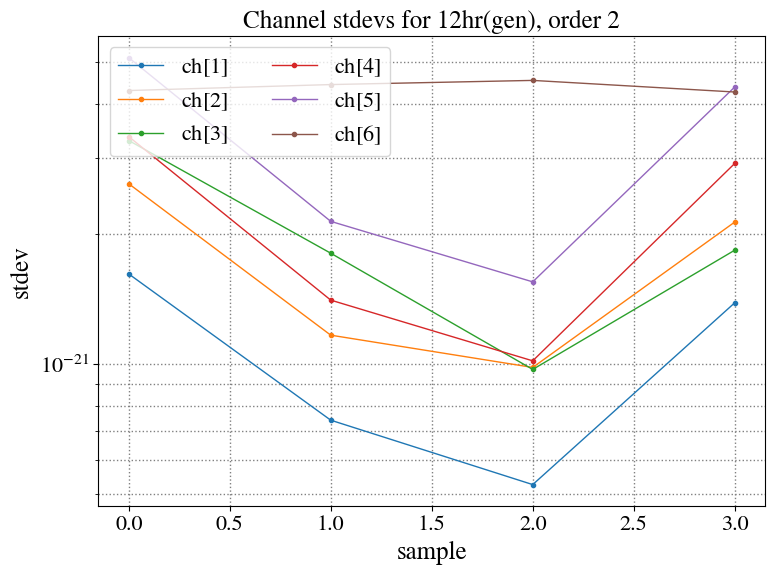

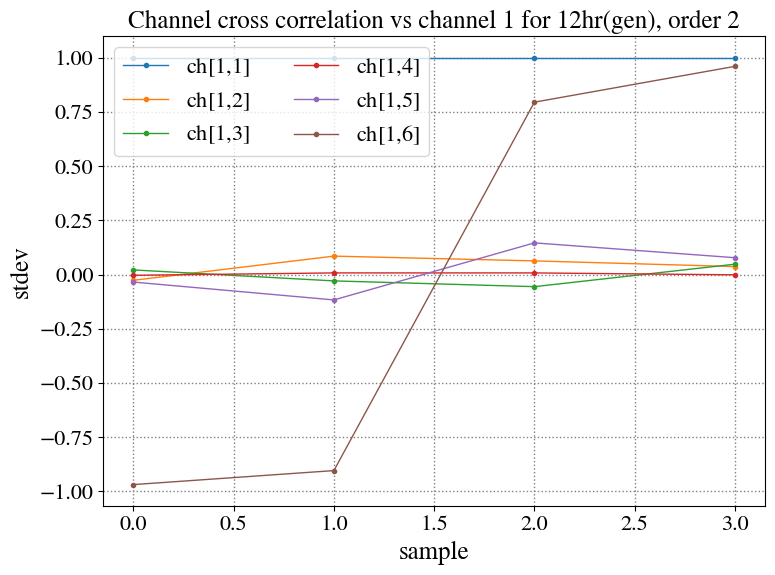

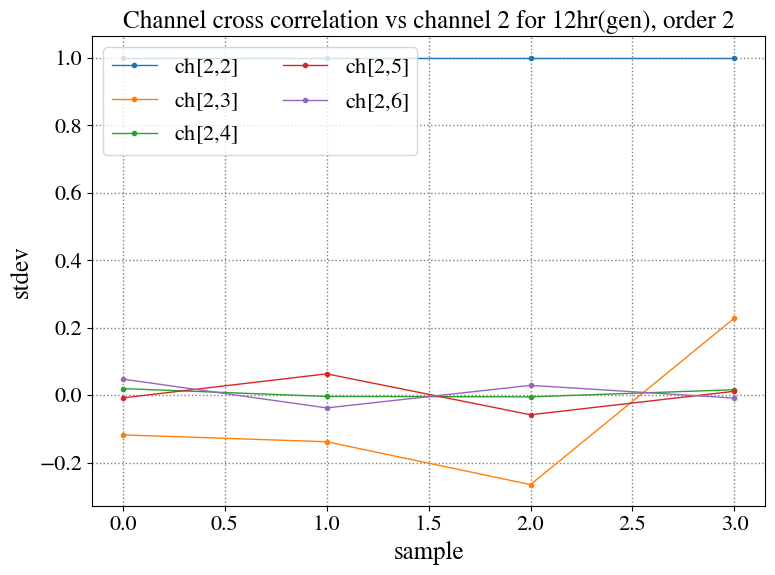

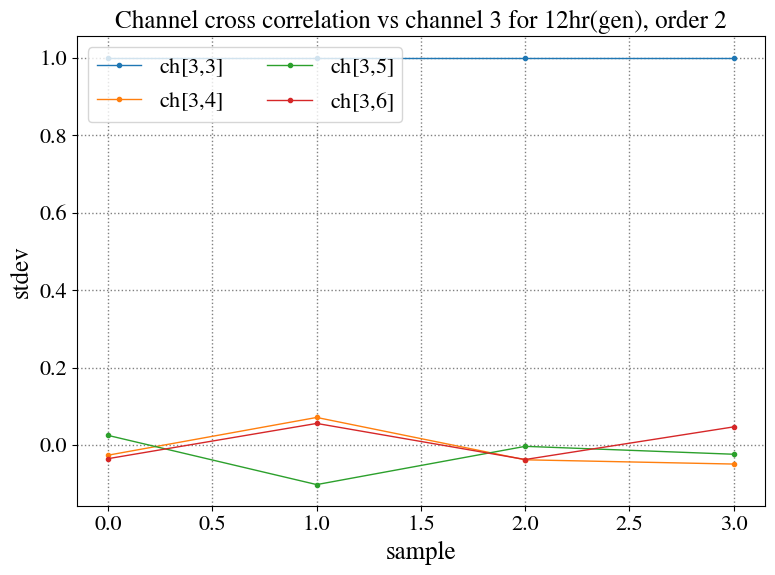

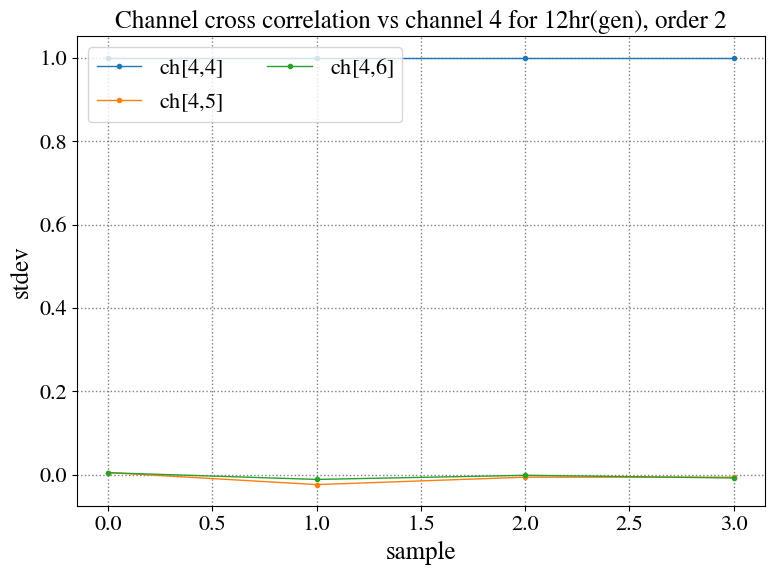

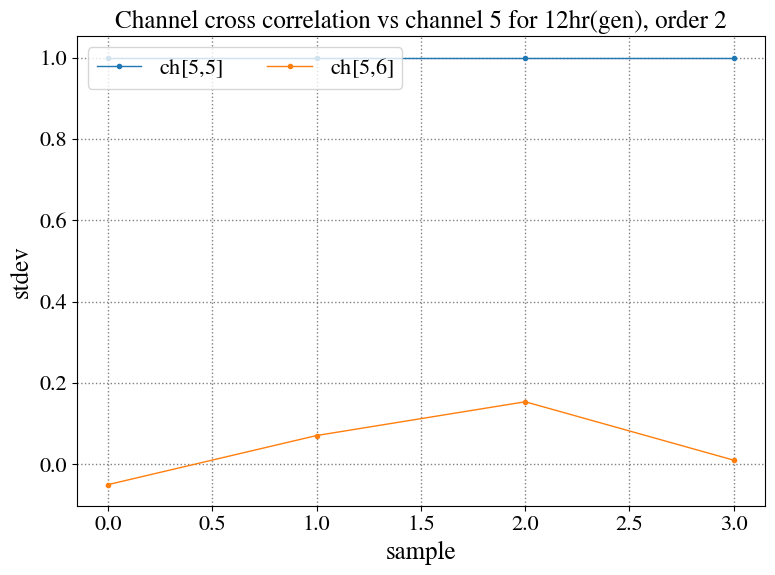

plotting 6 of 6 channels


/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


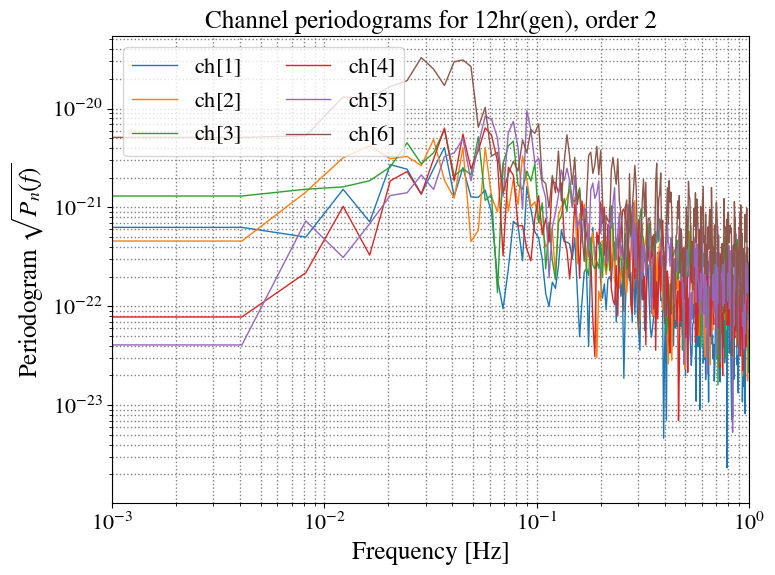

/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


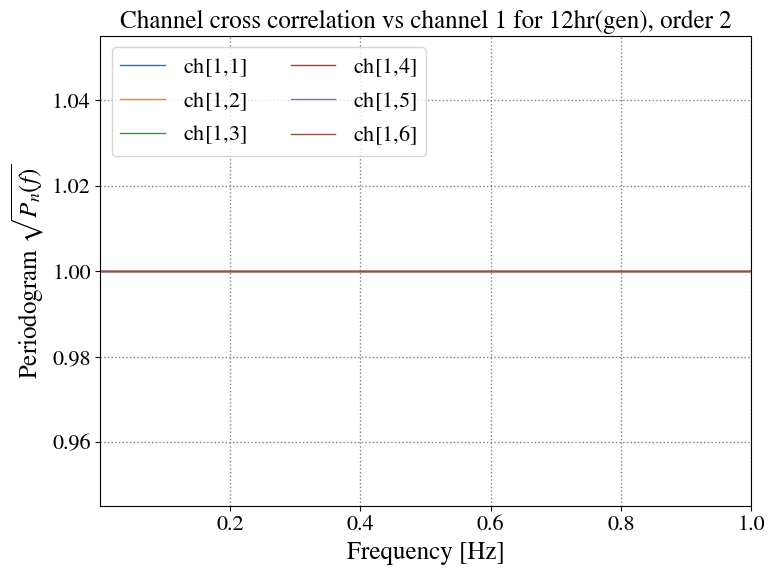

/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


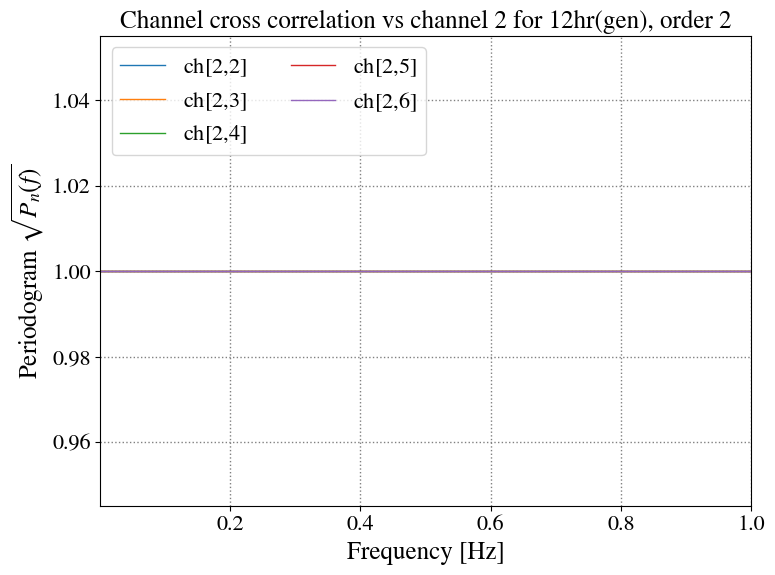

/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


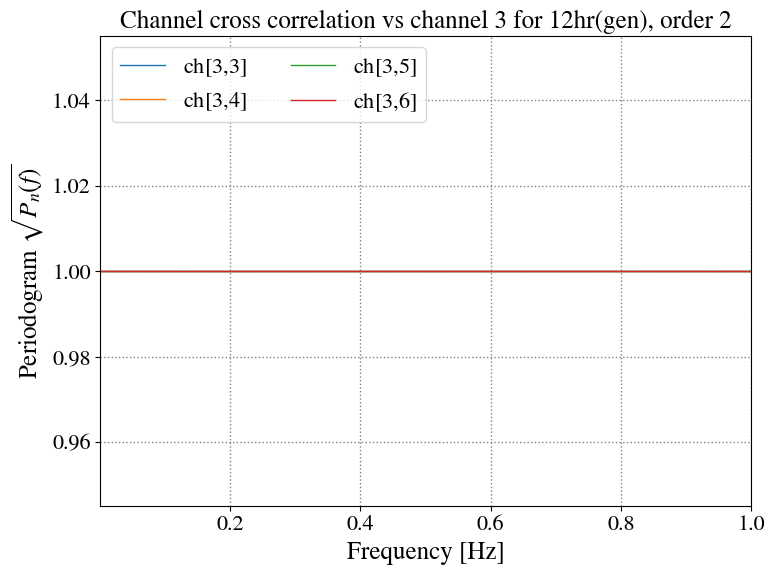

/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


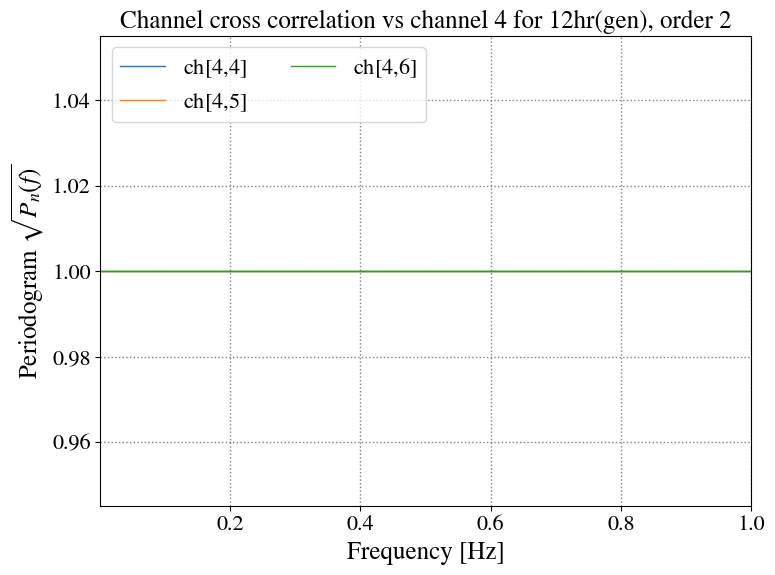

/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jgbaker/.conda/envs/pcienv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


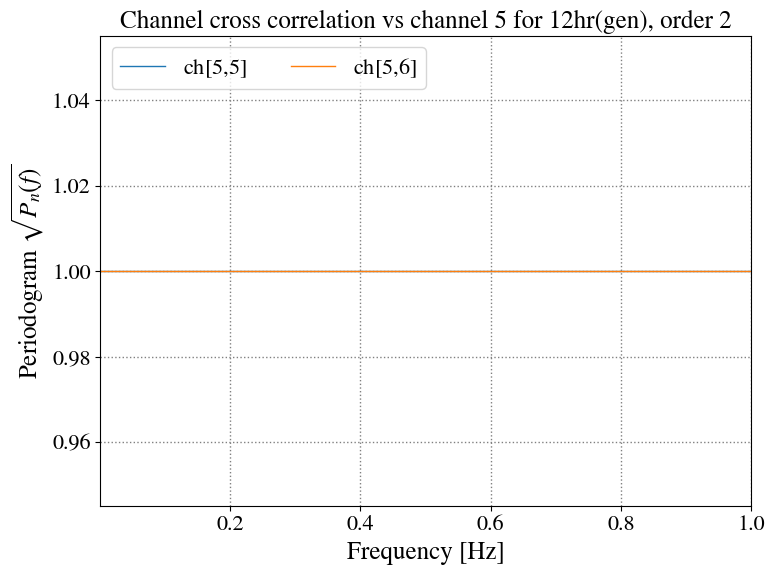

vh shape (21556, 6, 6) e_pci_f and selection shapes (6, 43110) (6, 43110)


In [21]:
print(x2_noise.shape)
print()
s=psd_sensitivity(orbits, fs, hp_nside=8, tref=0)
order=2
#s.compute_pci_sensitivity(pca_list[0], n_channels=6, y_noise_data=y_full.T, plots_label='full data, order 0')
s.compute_pci_sensitivity(pca_list[order], n_channels=6, y_noise_data=y_full[nhalf:ns+nhalf].T, plots_label='12hr(gen), order '+str(order))
#s.compute_pci_sensitivity(pca_list[0], n_channels=6, y_noise_data=None, plots_label='12hr(intrinsic), order 0')

### TBD new sensitivity calculation

$S_h(f)=\left[(F(f))^{ab}\Sigma^{-1}_{ab}(f)\right]^{-1}$

where

$\Sigma_{ab}=\left<n^*_a n_b\right>$

and

$F_{ab}(f)=\frac1{2N}\sum_{\lambda=1}^N\Re\left[{F^+_{\lambda\alpha}(f)}^*F^+_{\lambda\beta}(f)+{F^\times_{\lambda\alpha}(f)}^*F^\times_{\lambda\beta}(f)\right]$

where

$F^{+,\times}_{\lambda\alpha}(f)$

is the $\alpha$ channel response function to a point source in direction $\lambda$ for each polarization, and the sum is over a large number of evenly distributed point sources.


### Notes from GW2050 performance.py
$S(t, f) = \frac{1}{\text{Tr}[{C}_\text{strain}]}
        \text{Tr}[{C}_\text{signal}(t, f) {C}_\text{noise}^{-1}(t,
        f)].$

 Note that the normalized signal covariance matrix is often interpreted as
the response matrix, and the sensitivity is defined as the trace of the
product of the response and the inverse of the noise covariance matrix.

This definition is valid for any set of $N$ observables for which the
product ${C}_\text{signal} {C}_\text{noise}^{-1}$ is
full rank.

## 5. Measured Response to gravitational waves

### 5.1 Compute TDI transformation of GW signal data

In [22]:
import lisagwresponse
from lisagwresponse import StochasticPointSource, StochasticBackground# , GalacticBinary

In [23]:
# Instantiate GW signal class
def white_generator_at_1(fs, size):
    psd=1.0
    stddev = np.sqrt(psd * fs / 4)
    return np.random.normal(scale=stddev, size=size)

src_class = StochasticPointSource(white_generator_at_1,  
                                  orbits=orbits,
                                  gw_beta=np.pi/2, 
                                  gw_lambda=np.pi/2, 
                                  dt=dt, 
                                  t0=10, 
                                  size=n_data) 
#src_class = StochasticPointSource(1.0,  
#                                  orbits=orbits,
#                                  gw_beta=np.pi/2, 
#                                  gw_lambda=np.pi/2, 
#                                  dt=dt, 
#                                  t0=10, 
#                                  size=n_data)
# response = src_class.compute_gw_response(src_class.LINKS, src_class.t)

In [24]:
def load_measurements(gw_path, links, gw_dataset='tps/y'):
    
    # Science interferometer
    if type(gw_path) == str:
        hdf5 = h5py.File(gw_path, 'r')
        dset=hdf5[gw_dataset]
        measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(links)}
        hdf5.close()
    else:
        # If gw_path is a response array
        measurements = {f'isi_{link}': dset[ilink] for ilink, link in enumerate(links)}
    # Reference and test-mass interferometers
    for link in links:
        measurements[f'rfi_{link}'] = np.zeros(len(measurements[f'isi_{link}']))
        measurements[f'tmi_{link}'] = np.zeros(len(measurements[f'isi_{link}']))

    return measurements
#def load_measurements(gw_path, links, gw_dataset='tps/y'): #<--- modify key.  May also need to modify the names of the links
#    
#    # Science interferometer
#    if type(gw_path) == str:
#        hdf5 = h5py.File(gw_path, 'r')
#        hdf5.visit(print)
#        #help(hdf5)
#        #help(hdf5.attrs)
#        for item in hdf5.attrs.items():
#            print(item)
#        measurements = {f'isi_{link}': hdf5[gw_dataset][f'l_{link}'][()] for link in links}
#        hdf5.close()
#    else:
#        # If gw_path is a response array
#        measurements = {f'isi_{link}': gw_path[ilink] for ilink, link in enumerate(links)}
#    # Reference and test-mass interferometers
#    for link in links:
#        measurements[f'rfi_{link}'] = np.zeros(measurements[f'isi_{link}'].shape[0])
#        measurements[f'tmi_{link}'] = np.zeros(measurements[f'isi_{link}'].shape[0])

    return measurements
# def load_measurements(gw_path, links):
#     # Science interferometer
#     if type(gw_path) == str:
#         hdf5 = h5py.File(gw_path, 'r')
#         measurements = {f'isi_{link}': hdf5['l_' + link][()] for link in links}
#         hdf5.close()
#     else:
#         # If gw_path is a response array
#         measurements = {f'isi_{link}': gw_path[ilink] for ilink, link in enumerate(links)}
#     # Reference and test-mass interferometers
#     for link in links:
#         measurements[f'rfi_{link}'] = np.zeros(measurements[f'isi_{link}'].shape[0])
#         measurements[f'tmi_{link}'] = np.zeros(measurements[f'isi_{link}'].shape[0])

#     return measurements

In [25]:
# gw_path = '../data/realizations_gw/gw_pointsource_1.h5'
#gw_path = "/work/SC/lisa/baghiq/pci/simulations//2022-23-05_13h59_gw_measurements_4Hz.h5"
gw_path = datadir+"simulations/2024-04-10_18h35_gw_measurements_4Hz.h5"
measurements = load_measurements(gw_path, src_class.LINKS)
# measurements = load_measurements(response, src_class.LINKS)

# Apply TDI to GW signal
t = src_class.t0 + np.arange(src_class.size, dtype=np.float64) * src_class.dt
if lisagwresponse.__version__ == '1.0.1':
    delays = {f'd_{link}': src_class.tt[link](t) for link in src_class.LINKS}
else:
    delays = {f'd_{link}': src_class.ltt[int(link)](t) for link in src_class.LINKS}
data_gw = Data(measurements, delays, fs, delay_derivatives=None)

# Construct eta variables
ETA_data_gw_set = {key: ETA_SET[key].build(**data_gw.args) for key in ETA_SET.keys()}

In [26]:
eta_gw_set = {key: ETA_data_gw_set[key](data_gw.measurements) for key in ETA_data_gw_set.keys()}

In [27]:
# # Construct TDI X 2.0 variables
# x1_gw = X1_data(data_gw.measurements)
# y1_gw = Y1_data(data_gw.measurements)
# z1_gw = Z1_data(data_gw.measurements)
# # Construct TDI X 2.0 variables
# x2_gw = X2_data(data_gw.measurements)
# y2_gw = Y2_data(data_gw.measurements)
# z2_gw = Z2_data(data_gw.measurements)
# # Saving data
# path = '/work/SC/lisa/baghiq/pci/simulations/sgwb_tdi.h5'
# hdf5 = h5py.File(path, 'a')
# hdf5.create_dataset('x2', data=x2_gw)
# hdf5.create_dataset('y2', data=y2_gw)
# hdf5.create_dataset('z2', data=z2_gw)
# # Closing file
# hdf5.close()

tdi1_gw_file = datadir+"/simulations/2024-30-07_20h55_gw_tdi1_4Hz.h5"
tdi2_gw_file = datadir+"/simulations/2024-30-07_20h55_gw_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi1_gw_file, 'r')
x1_gw = hdf5['x1'][()]
y1_gw = hdf5['y1'][()]
z1_gw = hdf5['z1'][()]
hdf5.close()

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x2'][()]
y2_gw = hdf5['y2'][()]
z2_gw = hdf5['z2'][()]
hdf5.close()

In [28]:
# Compute TDI signal and noise spectra using Welch periodogram
nperseg = 1e4
kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

# For GW signal, use signal amplitude normalization
kwargs_gw = copy.deepcopy(kwargs)
# kwargs_gw["scaling"] = "spectrum"
# Compute welch matrix for the TDI 1.5 noise
#e_tdi1_n = np.array([x1_noise[skip:skip+ns] / instr.central_freq,
#                     y1_noise[skip:skip+ns] / instr.central_freq,
#                     z1_noise[skip:skip+ns] / instr.central_freq]).T
#freqs, p_tdi1_n_mat = compute_welch_matrix(e_tdi1_n, **kwargs)
# Compute the welch matrix for the TDI 1.5 GW signal
#e_tdi1_gw = np.array([x1_gw[skip:skip+ns],
#                      y1_gw[skip:skip+ns],
#                      z1_gw[skip:skip+ns]]).T
#freqs, p_tdi1_gw_mat = compute_welch_matrix(e_tdi1_gw, **kwargs_gw)
# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **kwargs_gw)

In [29]:
# Compute single-link signal and noise spectra
single_link_gw = [signal.welch(measurements[f'isi_{link}'][skip:skip+ns], **kwargs_gw) for link in src_class.LINKS]
eta_gw = [signal.welch(eta_gw_set[f'eta_{link}'][skip:skip+ns], **kwargs_gw) for link in src_class.LINKS]

### 5.2 Compute 0th order APCI transformation of GW signal data

In [30]:
def periodogram(x, fs, scaling='density', wd=None):
    if wd is None:
        wd = np.blackman(x.shape[0])
    if scaling=='density':
        k2 = np.sum(wd**2)
        pd = np.abs(fft(x*wd))**2 * 2 / (k2 * fs)
    elif scaling=='spectrum':
        k1 = np.sum(wd)
        pd = np.abs(fft(x*wd) * 2 / k1)**2
    return pd

In [31]:
# Compute Welch periodogram of GW signal in PCI variables
# Form the signal vector
mosas_order = ['12', '23', '31', '13', '21', '32']
y_list = [measurements[f'isi_{link}'] for link in mosas_order]
y_gw = np.array(y_list, dtype=np.float64).T
# Avoinding non-zero entries
datamatrix_gw = apci.build_data_matrix(y_gw[skip:skip+ns+2*nhalf, :].T, 
                                  nhalf=nhalf, 
                                  window=np.ones(ns + 2*nhalf))

datamatrix_gw = datamatrix_gw[nhalf:-nhalf, :] * window[:, np.newaxis]
# Choose only six PCI componentsconstruct
n_components = 6
e_pci_gw_0 = [pca_list[0].components_[-n_components+i, :].dot(datamatrix_gw.astype(np.float64).T) 
              for i in range(n_components)]

p_pci_gw_0 = np.array([signal.welch(e_pci_gw_0[j], **kwargs_gw)[1] for j in range(len(e_pci_gw_0))])

NameError: name 'apci_data' is not defined

### 5.3 Compute 1st order APCI transformation of GW signal data

In [ ]:
# Compute the PCI 2.0 output periodogram
datamatrix_gw_1 = build_data_matrix_2(y_gw[skip:skip+ns+2*nhalf, :].T, 
                                      nhalf=nhalf, 
                                      window=np.ones(ns + 2*nhalf),
                                      order=1)
datamatrix_gw_1 = datamatrix_gw_1[nhalf:-nhalf, :] * window[:, np.newaxis]
e_pci_gw_1 = [pca_list[1].components_[-n_components+i, :].dot(datamatrix_gw_1.astype(np.float64).T) 
              for i in range(n_components)]
# Welch periodograms for PCI 1 variables
p_pci_gw_1 = np.array([signal.welch(e_pci_gw_1[j], **kwargs_gw)[1] for j in range(len(e_pci_gw_1))])
del datamatrix_gw_1 

In [ ]:
# Welch periodograms for PCI noises (0th order)
p_pci_n_0 = np.array([signal.welch(e_pci_list[0][j], **kwargs)[1] for j in range(6)])
# Welch periodograms for PCI noises (1st order)
p_pci_n_1 = np.array([signal.welch(e_pci_list[1][j], **kwargs)[1] for j in range(6)])

### 5.4 Compute 2nd order APCI transformation of GW signal data

In [ ]:
###Can we package this into

# Compute the PCI 2.0 output periodogram
datamatrix_gw_2 = build_data_matrix_2(y_gw[skip:skip+ns+2*nhalf, :].T, 
                                      nhalf=nhalf, 
                                      window=np.ones(ns + 2*nhalf),
                                      order=2)
datamatrix_gw_2 = datamatrix_gw_2[nhalf:-nhalf, :] * window[:, np.newaxis]
e_pci_gw_2 = [pca_list[2].components_[-n_components+i, :].dot(datamatrix_gw_2.astype(np.float64).T) 
              for i in range(n_components)]
del datamatrix_gw_2 

In [ ]:
# WWelch periodograms for PCI variables from laser noise
p_pci_n_2 = np.array([signal.welch(e_pci_list[2][j], **kwargs)[1] for j in range(6)])
# Welch periodograms for PCI variables from GW source
p_pci_gw_2 = np.array([signal.welch(e_pci_gw_2[j], **kwargs_gw)[1] for j in range(6)])

### 5.5 Periodograms of noise-only streams

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
# For TDI
axes.loglog(freqs, np.sqrt(p_tdi2_n_mat[:, 0, 0]), linewidth=1, label='TDI X 2.0')
# For APCI
for j_pci in range(6):
    axes.loglog(freqs, np.sqrt(p_pci_n_1[j_pci]), linewidth=1, label=r'$\mathrm{PCI}_{1}$[' + str(j_pci+1) + ']')
axes.legend(loc='upper left', ncol=2)
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Periodogram $\sqrt{P_{n}(f)}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-16])
axes.set_title("Noise periodograms (degree 1)")
plt.show()

### 5.6 Periodograms of GW-only streams

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
# For TDI
axes.loglog(freqs, np.sqrt(p_tdi2_gw_mat[:, 0, 0]), linewidth=1, label='TDI X 2.0')
# For APCI
for j_pci in range(6):
    axes.loglog(freqs, np.sqrt(np.abs(p_pci_gw_0[j_pci])), 
                linewidth=1, label=r'$\mathrm{PCI}_{0}$[' + str(j_pci+1) + ']')
axes.legend(loc='upper left', ncol=2)
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$P_{\mathrm{GW}}(f)$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-16])
axes.set_title("GW response estimates (degree 0)")
plt.show()

### 5.6 Computation of empirical response with welch periodograms

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
# For TDI
axes.loglog(freqs, np.sqrt(p_tdi2_n_mat[:, 0, 0]/p_tdi2_gw_mat[:, 0, 0]), linewidth=1, label='TDI X 2.0')
# For APCI
for j_pci in range(6):
    axes.loglog(freqs, np.sqrt(p_pci_n_0[j_pci] / np.abs(p_pci_gw_0[j_pci])), 
                linewidth=1, label=r'$\mathrm{PCI}_{0}$[' + str(j_pci+1) + ']')
axes.legend(loc='upper left', ncol=2)
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-16])
axes.set_title("Sensitivity estimates (degree 0)")
plt.show()

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
# For TDI
axes.loglog(freqs, np.sqrt(p_tdi2_n_mat[:, 0, 0]/p_tdi2_gw_mat[:, 0, 0]), linewidth=1, label='TDI X 2.0')
# For APCI
for j_pci in range(6):
    axes.loglog(freqs, np.sqrt(p_pci_n_1[j_pci] / np.abs(p_pci_gw_1[j_pci])), 
                linewidth=1, label=r'$\mathrm{PCI}_{1}$[' + str(j_pci+1) + ']')
axes.legend(loc='upper left', ncol=2)
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-16])
axes.set_title("Sensitivity estimates (degree 1)")
plt.show()

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
# For TDI
axes.loglog(freqs, np.sqrt(p_tdi2_n_mat[:, 0, 0]/p_tdi2_gw_mat[:, 0, 0]), linewidth=1, label='TDI X 2.0')
# For APCI
for j_pci in range(6):
    axes.loglog(freqs, np.sqrt(p_pci_n_2[j_pci] / np.abs(p_pci_gw_2[j_pci])), 
                linewidth=1, label=r'$\mathrm{PCI}_{2}$[' + str(j_pci+1) + ']')
axes.legend(loc='upper left', ncol=2)
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-16])
axes.set_title("Sensitivity estimates (degree 2)")
plt.show()

### 5.7 Orthogonalization

#### Empirical orthogonalization of TDI

In [ ]:
help(eigen.multiple_dot)

In [ ]:
# Orthogonalization
u_tdi, s_tdi, vh_tdi = np.linalg.svd(p_tdi2_n_mat)
# w_tdi, v_tdi = np.linalg.eig(e_tdi_n_mat)

In [ ]:
# Apply the orthogonal transformation to the GW signal
p_tdi2_gw_mat_ortho = eigen.multiple_dot(vh_tdi, eigen.multiple_dot(p_tdi2_gw_mat, np.swapaxes(vh_tdi, 1, 2).conj()))
# e_tdi_gw_mat_ortho = eigen.multiple_dot(np.swapaxes(v_tdi, 1, 2).conj(), eigen.multiple_dot(e_tdi_gw_mat, v_tdi))

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
# For TDI
axes.loglog(freqs, np.sqrt(np.abs(s_tdi[:, 0] / p_tdi2_gw_mat_ortho[:, 0, 0])), linewidth=1, label='Empirical A')
axes.loglog(freqs, np.sqrt(np.abs(s_tdi[:, 1] / p_tdi2_gw_mat_ortho[:, 1, 1])), linewidth=1, label='Empirical E')
axes.loglog(freqs, np.abs(np.sqrt(s_tdi[:, 2] / p_tdi2_gw_mat_ortho[:, 2, 2])), linewidth=1, label='Empirical T')
# # For APCI
# for j_pci in range(6):
#     axes.loglog(f_gw_x, np.sqrt(p_pci_n_1[j_pci]), linewidth=1, label=r'$\mathrm{PCI}_{1}$[' + str(j_pci+1) + ']')
# axes.legend(loc='upper left', ncol=2)
# axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
# axes.set_xlabel("Frequency [Hz]")
# axes.set_ylabel(r"Periodogram $\sqrt{P_{n}(f)}$")
# axes.set_xlim([1e-3, 1])
# # axes.set_ylim([1e-21, 1e-16])
axes.set_title("Sensitivity of orthogonalized TDI")
axes.legend(loc='upper left')
plt.show()
!free

#### Standard TDI A, E, T

In [ ]:
# AET matrix
aet_mat = np.array([[-1/np.sqrt(2), 0, 1/np.sqrt(2)],
                    [1/np.sqrt(6), -2/np.sqrt(6), 1/np.sqrt(6)],
                    [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]])

In [ ]:
# Project noise onto AET basis
p_aet2_n_mat = eigen.multiple_dot(aet_mat[np.newaxis, :, :], 
eigen.multiple_dot(p_tdi2_n_mat, np.swapaxes(aet_mat[np.newaxis, :, :], 1, 2)))
# Project signal onto AET basis
p_aet2_gw_mat = eigen.multiple_dot(aet_mat[np.newaxis, :, :], 
eigen.multiple_dot(p_tdi2_gw_mat, np.swapaxes(aet_mat[np.newaxis, :, :], 1, 2)))

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
# For TDI
tdi_labels = [r'$A$', r'$E$', r'$T$']
for j in range(3):
    axes.loglog(freqs, np.sqrt(np.abs(p_aet2_n_mat[:, j, j] / p_aet2_gw_mat[:, j, j])), 
                linewidth=1, label=tdi_labels[j])
# # axes.set_ylim([1e-21, 1e-16])
axes.set_title("Sensitivity of orthogonalized TDI")
axes.legend(loc='upper left')
plt.show()
!free

#### Orthogonalization of 1st order PCI

In [ ]:
# Compute welch matrix for the APCI noise
e_pci_n1 = np.array([e_pci_list[1][j] for j in range(6)]).T
freqs, p_pci1_n_mat = compute_welch_matrix(e_pci_n1, **kwargs)
# Orthogonalization
u, s, vh = np.linalg.svd(p_pci1_n_mat)

In [ ]:
# Compute Welch matrix for the GW signal
e_pci_gw1 = np.array([e_pci_gw_1[j] for j in range(6)]).T
freqs, p_pci1_gw_mat = compute_welch_matrix(e_pci_gw1, **kwargs_gw)
# Apply the orthogonal transformation to the GW signal
p_pci1_gw_mat_ortho = eigen.multiple_dot(vh, eigen.multiple_dot(p_pci1_gw_mat, np.swapaxes(vh, 1, 2).conj()))
print(p_pci1_gw_mat_ortho.shape)
print(s.shape)

In [ ]:
# Compute PCI equivalent vector for the noise# Compute PCI equivalent vector for the noiseplotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
tdi_labels = [r'$\hat{A}$', r'$\hat{E}$', r'$\hat{T}$']
for j_tdi in range(0, 3):
    axes.loglog(freqs, np.sqrt(np.abs(s_tdi[:, j_tdi] / p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi])), 
                linewidth=1, label=tdi_labels[j_tdi],
                color='black', alpha=0.9**j_tdi)
for j_pci in range(0, 3):
    axes.loglog(freqs, np.sqrt(np.abs(s[:, j_pci] / p_pci1_gw_mat_ortho[:, j_pci, j_pci])), 
                linewidth=1, label=r'$\mathrm{PCI}_{1}$[' + str(j_pci+1) + ']')
axes.legend(loc='upper left', ncol=2)
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-16])
axes.set_title("Sensitivity of orthogonalized variables")
plt.show()
!free

In [ ]:
# Empirical orthogonalization of TDI
mean_tdi2 = 1 / np.sum(
    np.array([np.abs(p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi] / np.abs(s_tdi[:, j_tdi])) for j_tdi in range(3)]), axis=0)
# Standard AET 
mean_aet2 = 1 / np.sum(
    np.array([np.abs(p_aet2_gw_mat[:, j, j] / p_aet2_n_mat[:, j, j]) for j in range(3)]), axis=0)
# Empritical orthogonalization of PCI
mean_pci1 = 1 / np.sum(
    np.array([np.abs(p_pci1_gw_mat_ortho[:, j_pci, j_pci] / s[:, j_pci]) for j_pci in range(6)]), axis=0)

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
tdi_labels = [r'$\hat{A}$', r'$\hat{E}$', r'$\hat{T}$']
axes.loglog(freqs, np.sqrt(mean_tdi2), 
            linewidth=1, label=r'TDI (empirical $\perp$)',
            color='black')
axes.loglog(freqs, np.sqrt(mean_aet2), 
            linewidth=1, label=r'TDI (standard AET)',
            color='gray')
axes.loglog(freqs, np.sqrt(mean_pci1), 
            linewidth=1, label=r'PCI (1st order)')
axes.legend(loc='upper left', ncol=2)
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-16])
axes.set_title("Sensitivity of orthogonalized variables (average)")
plt.show()
!free

## 6 Parameter option investigations

### 6.1 Impact of stencil size

In [ ]:
def analyse_data(y_noise, nhalf, order=1):
    """
    Perform the principal component analysis of measurements y
    """
    # Get the length of the time series
    data_size = y_noise.shape[0]
    # Produce the data matrix to avoiding zero entries, size ns x p
    datamatrix_n = build_data_matrix_2(y_noise.T, 
                                       nhalf=nhalf, 
                                       window=np.ones(data_size),
                                       order=order)
    # Select only non-zero entries
    window = np.ones(data_size-2*nhalf)
    datamatrix_n = datamatrix_n[nhalf:-nhalf, :] * window[:, np.newaxis]
    # Compute PCA
    pca = PCA().fit(datamatrix_n)
    
    return pca


def estimate_sensitivity(pca, datamatrix_n, datamatrix_gw, n_channels=6, **kwargs):
    
    # PCI transformation vector, size n_channel x p
    v_pci = np.array([pca.components_[-n_channels+i, :] for i in range(n_channels)])
    # Projection of the data segment t
    e_pci_n = np.array([v.dot(datamatrix_n.astype(np.float64).T) for v in v_pci]).T
    e_pci_gw = np.array([v.dot(datamatrix_gw.astype(np.float64).T) for v in v_pci]).T
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_n_mat = compute_welch_matrix(e_pci_n, **kwargs)
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_gw_mat = compute_welch_matrix(e_pci_gw, **kwargs_gw)
    # Orthogonalization
    _, s, vh = np.linalg.svd(e_pci_n_mat)
    # Apply the orthogonal transformation to the GW signal
    e_pci_gw_mat_ortho = eigen.multiple_dot(vh, eigen.multiple_dot(e_pci_gw_mat, np.swapaxes(vh, 1, 2).conj()))
    # Apply the orthogonal transformation to the noise covariance
    e_pci_n_mat_ortho = eigen.multiple_dot(vh, eigen.multiple_dot(e_pci_n_mat, np.swapaxes(vh, 1, 2).conj()))
    # Output sensitivity for each variable, size nfreqs x n_channels
    # pci_sens = np.array([np.abs(s[:, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    pci_sens = np.array([np.abs(e_pci_n_mat_ortho[:, j, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    print("Computation completed.")
    
    return freqs, pci_sens

def process_data(y_noise, y_gw, ns, nhalf, order=1, n_channels=6, pca=None, **kwargs):

    print('nhalf:',nhalf, 'date_size:',len(y_noise))
    
    # Get the length of the time series
    data_size = y_noise.shape[0]
    # data_noise = Data.from_instrument(instr_data)
    kwargs_gw = copy.deepcopy(kwargs)
#     kwargs_gw["scaling"] = "spectrum"

    # Produce the data matrix to avoiding zero entries, size ns x p
    #print('free before datamatrix_n:')
    #!free
    datamatrix_n = build_data_matrix_2(y_noise.T, 
                                       nhalf=nhalf, 
                                       window=np.ones(data_size),
                                       order=order)
    #print('free before datamatrix_gw:')
    #!free
    # Same thing for the signal
    datamatrix_gw = build_data_matrix_2(y_gw.T, 
                                        nhalf=nhalf, 
                                        window=np.ones(data_size),
                                        order=order)
    # Select only non-zero entries
    window = np.ones(data_size-2*nhalf)
    datamatrix_n = datamatrix_n[nhalf:-nhalf, :] * window[:, np.newaxis]
    datamatrix_gw = datamatrix_gw[nhalf:-nhalf, :] * window[:, np.newaxis]
    # Compute PCA
    #print('free before pca:')
    #!free
    if pca is None:
        pca = PCA().fit(datamatrix_n)
    #print('free before return:')
    #!free
    
    return estimate_sensitivity(pca, datamatrix_n, datamatrix_gw, n_channels=6, **kwargs)

In [ ]:
def process_data_tdi(y_noise, y_gw, ns, nhalf, order=1, n_channels=6, pca=None, **kwargs):
    
    pass

In [ ]:
# PCI sensitivity for fixed noise / signal and various stencil sizes
#nh_list = [30, 35, 40, 45, 50, 55, 60, 65, 70]
nh_list = [30, 35, 37, 39, 40, 41, 42, 43, 44, 45, 50, 60, 70]
pci_sens_list = [process_data(y_full[:ns, :], y_gw[0:ns, :], ns, nh, order=1, n_channels=6, pca=None, **kwargs) for nh in nh_list]
pci_sens_mean_list_nh = [1 / np.sum(1/np.array(pci_sens[1]), axis=1) for pci_sens in pci_sens_list]

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_aet2*ns/fs), 
            linewidth=1, label=r'TDI (standard AET)',
            color='black', rasterized=True)
for j in range(len(nh_list)):
    axes.loglog(pci_sens_list[0][0], np.sqrt(pci_sens_mean_list_nh[j]*ns/fs), 
                linewidth=1, label=r'PCI $n_h =$' + str(nh_list[j]), rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 2])
axes.set_ylim([1e-19, 1e-10])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined variables (average)")
plt.show()

In [ ]:
print(np.array(pci_sens_mean_list_nh).shape)

ii = np.where(pci_sens_list[0][0] <= 4e-1)[0]

In [ ]:
full_snr_nh = np.sum(1/np.array(pci_sens_mean_list_nh), axis=1)
full_snr_tdi2 = np.sum(1/mean_tdi2)
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.set_xlabel("Stencil size [samples]")
axes.set_ylabel(r"SNR")
axes.plot(np.array(nh_list), np.sqrt(full_snr_nh))
# Set visibility of ticks & tick labels
axes.tick_params(axis="x", which="both", direction="in", 
                 top=True, labeltop=False, bottom=True, labelbottom=True)
axes.tick_params(axis="y", which="both", direction="in", 
                 left=True, labelleft=True, right=True, labelright=False)
# axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlim([nh_list[0], nh_list[-1]])
plt.show()

### 6.2 Impact of time order

#### 6.1 Orthogonalization of 0th-order PCI

In [ ]:
# Compute welch matrix for the APCI noise
e_pci_n0 = np.array([e_pci_list[0][j] for j in range(6)]).T
freqs, p_pci0_n_mat = compute_welch_matrix(e_pci_n0, **kwargs)
# Orthogonalization
u, s0, vh = np.linalg.svd(p_pci0_n_mat)
# Compute Welch matrix for the GW signal
e_pci_gw0 = np.array([e_pci_gw_0[j] for j in range(6)]).T
freqs, p_pci0_gw_mat = compute_welch_matrix(e_pci_gw0, **kwargs)
# Apply the orthogonal transformation to the GW signal
p_pci0_gw_mat_ortho = eigen.multiple_dot(vh, eigen.multiple_dot(p_pci0_gw_mat, np.swapaxes(vh, 1, 2).conj()))

#### 6.2 Orthogonalization of 2nd-order PCI

In [ ]:
# Compute welch matrix for the APCI noise
e_pci_n2 = np.array([e_pci_list[2][j] for j in range(6)]).T
freqs, p_pci2_n_mat = compute_welch_matrix(e_pci_n2, **kwargs)
# Orthogonalization
u, s2, vh = np.linalg.svd(p_pci2_n_mat)
# Compute Welch matrix for the GW signal
e_pci_gw2 = np.array([e_pci_gw_2[j] for j in range(6)]).T
freqs, p_pci2_gw_mat = compute_welch_matrix(e_pci_gw2, **kwargs)
# Apply the orthogonal transformation to the GW signal
p_pci2_gw_mat_ortho = eigen.multiple_dot(vh, eigen.multiple_dot(p_pci2_gw_mat, np.swapaxes(vh, 1, 2).conj()))

#### 6.3 Comparison of full sensitivities

In [ ]:
# Summed 0th order APCI sensitivity
mean_pci0 = 1 / np.sum(
    np.array([np.abs(p_pci0_gw_mat_ortho[:, j_pci, j_pci] / s0[:, j_pci]) for j_pci in range(6)]), axis=0)
# Summed 2nd order APCI sensitivity
mean_pci2 = 1 / np.sum(
    np.array([np.abs(p_pci2_gw_mat_ortho[:, j_pci, j_pci] / s2[:, j_pci]) for j_pci in range(6)]), axis=0)

In [ ]:
mean_aet2.shape

In [ ]:
# Observation time
ts = ns / fs
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_aet2*ts), 
            linewidth=1, label=r'TDI (standard AET)',
            color='gray')
axes.loglog(freqs, np.sqrt(mean_pci0*ts), 
            linewidth=1, label=r'PCI (0th order)')
axes.loglog(freqs, np.sqrt(mean_pci1*ts), 
            linewidth=1, label=r'PCI (1st order)')
axes.loglog(freqs, np.sqrt(mean_pci2*ts), 
            linewidth=1, label=r'PCI (2nd order)')
axes.legend(loc='upper left', ncol=2)
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-16])
axes.set_title("Sensitivity of orthogonalized variables (average)")
plt.show()

### 6.3 Impact of data size

In [ ]:
# Compute data matrices for a fixed data size (for post-processing only)
ns_fixed = int(24 * 3600 * fs)
# For the noise
datamatrix_n = build_data_matrix_2(y_full[0:ns_fixed, :].T, 
                                   nhalf=nhalf, 
                                   window=np.ones(ns_fixed),
                                   order=1)
# Same thing for the signal
datamatrix_gw = build_data_matrix_2(y_gw[0:ns_fixed, :].T, 
                                    nhalf=nhalf, 
                                    window=np.ones(ns_fixed),
                                    order=1)
# Select only non-zero entries
window = np.ones(ns_fixed - 2*nhalf)
datamatrix_n = datamatrix_n[nhalf:-nhalf, :] * window[:, np.newaxis]
datamatrix_gw = datamatrix_gw[nhalf:-nhalf, :] * window[:, np.newaxis]

In [ ]:
print(ns/fs/(3600))
print(y_full.shape[0]/fs/3600)
print(y_full.shape)

In [ ]:
# PCI sensitivity for fixed noise / signal /stencil size and various data sizes
ns_list = [int(ns/8*i) for i in range(1, 9)]
# For segments with increasing sizes, derive PCA vectors
pci_sens_list = []
for nsegment in ns_list:
    # Analyze sample
    pca = analyse_data(y_full[0:nsegment, :], nhalf, order=1)
    # Apply to the original data
    pci_sens_list.append(estimate_sensitivity(pca, datamatrix_n, datamatrix_gw, n_channels=6, **kwargs))
    
pci_sens_mean_list = [1 / np.sum(1/np.array(pci_sens[1]), axis=1) for pci_sens in pci_sens_list]

In [ ]:
ts_list = np.array(ns_list)/fs
for tau in ts_list:
    print("Duration (hours): ", tau/3600)

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
# axes.loglog(freqs, np.sqrt(mean_aet2), 
#             linewidth=1, label=r'TDI (standard AET)',
#             color='gray', rasterized=True)
for j in range(1, len(ns_list)):
    axes.loglog(freqs, np.sqrt(pci_sens_mean_list[j]), 
                linewidth=1, label=r'PCI $n_s =$' + str(ns_list[j]), rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-17])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of orthogonalized variables (average)")
plt.show()

In [ ]:
full_snr = np.sqrt(np.sum(1/np.array(pci_sens_mean_list), axis=1)*ts_list)

plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.set_xlabel("Duration [hours]")
axes.set_ylabel(r"SNR")
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
# axes.plot(np.array(ns_list)/fs/(3600), full_snr*np.sqrt(fs/np.array(ns_list)), label='Averaged
axes.plot(np.array(ns_list)/fs/(3600), full_snr, label='Averaged')
# axes.plot(np.array(ns_list[1:])/fs/(3600), full_snr[1:], label='Summed SNR')
# axes.legend(loc='upper left', ncol=1)
axes.set_title("Integrated SNR vs duration")
plt.show()

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.set_xlabel("Duration [hours]")
axes.set_ylabel(r"$T_{\mathrm{obs}}^{-1/2} \times \mathrm{SNR}$")
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
# axes.plot(np.array(ns_list)/fs/(3600), full_snr*np.sqrt(fs/np.array(ns_list)), label='Averaged
axes.plot(np.array(ns_list)/fs/(3600), full_snr/np.sqrt(ts_list), label='Averaged')
# axes.plot(np.array(ns_list[1:])/fs/(3600), full_snr[1:], label='Summed SNR')
axes.set_title(r"Rescaled integrated SNR vs duration")
plt.show()

### 6.4 Impact of number of components

In [ ]:
# Produce the data matrix to avoiding zero entries, size ns x p
datamatrix_n = build_data_matrix_2(y_full[0:ns+2*nhalf, :].T, 
                                   nhalf=nhalf, 
                                   window=np.ones(ns+2*nhalf),
                                   order=1)
# Same thing for the signal
datamatrix_gw = build_data_matrix_2(y_gw[0:ns+2*nhalf, :].T, 
                                    nhalf=nhalf, 
                                    window=np.ones(ns+2*nhalf),
                                    order=1)
# Select only non-zero entries
window = np.ones(ns)
datamatrix_n = datamatrix_n[nhalf:-nhalf, :] * window[:, np.newaxis]
datamatrix_gw = datamatrix_gw[nhalf:-nhalf, :] * window[:, np.newaxis]

In [ ]:
ncomps = np.arange(1, 11)
pci_sens_list_ncomp = [estimate_sensitivity(pca_list[1], datamatrix_n, datamatrix_gw, n_channels=n_c, **kwargs)
                       for n_c in ncomps]

In [ ]:
# Compute averaged sensitivities over all components
pci_sens_mean_list_ncomp = [1 / np.sum(1/np.array(pci_sens[1]), axis=1) for pci_sens in pci_sens_list_ncomp]

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
for j in range(len(ncomps)):
    axes.loglog(pci_sens_list_ncomp[0][0], np.sqrt(pci_sens_mean_list_ncomp[j]), 
                linewidth=1, label=str(ncomps[j]) + " components", rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-17])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity vs component number")
plt.show()

In [ ]:
full_snr_ncomp = np.sum(1/np.array(pci_sens_mean_list_ncomp), axis=1)
full_snr_tdi2 = np.sum(1/mean_tdi2)
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.set_xlabel("Number of components")
axes.set_ylabel(r"SNR fraction")
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.plot(ncomps, full_snr_ncomp / full_snr_tdi2)
axes.set_title("Full SNR fraction (wrt TDI2) vs component number")
plt.show()

In [ ]:
mean_tdi2.shape

## 7. Relation with single-link space

In [ ]:
# Project data matrix onto principal components
# t_all = datamatrix_list[1].astype(np.float64).dot(pca_list[1].components_.T)
# print(t_all.shape)
t_q = datamatrix_list[1].astype(np.float64).dot(pca_list[1].components_[-n_channels:, :].T)

In [ ]:
# Set all high variance components to zero
# t_all[:, 0:-n_channels] = 0
# Convert back to original space
denoised_matrix = t_q.dot(pca_list[1].components_[-n_channels:, :])
print(denoised_matrix.shape)

In [ ]:
# Verification of the location of unshifted data
nc = 6
y_input = y_full[0:ns+2*nhalf, :][nhalf:-nhalf, :]
y_output = datamatrix_list[1][:, nhalf*nc:(nhalf+1)*nc]
print(y_input.shape)
print(y_output.shape)
# Check egality
print(y_input[10, :])
print(y_output[10, :])

In [ ]:
# Select only unshifted data
y_denoised = denoised_matrix[:, nhalf*nc:(nhalf+1)*nc]
print(y_denoised.shape)

In [ ]:
# Empirical spectrum matrix of raw data
fy, py = compute_welch_matrix(y_full[nhalf:-nhalf, :], **kwargs)
# Empirical spectrum matrix of denoised data
fy_den, py_den = compute_welch_matrix(y_denoised, **kwargs)
# Empirical spectrum matrix of secondary noises
fy, py_sec = compute_welch_matrix(y_sec[nhalf:-nhalf, :], **kwargs)

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
mosas_order = ['12', '23', '31', '13', '21', '32']
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
for j in range(6):
    axes.loglog(fy, np.sqrt(py[:, j, j]), 
                linewidth=1, 
                color=colors[j],
                alpha=0.5,
                label=mosas_order[j], 
                rasterized=True)
    axes.loglog(fy, np.sqrt(py_den[:, j, j]), 
                linewidth=1,
                color=colors[j],
                rasterized=True)
    #axes.loglog(fy, np.sqrt(py_sec[:, j, j]), 
    #            linewidth=1,
    #            color='k',
    #            rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Link PSD $\mathrm{Hz^{-1/2}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-17])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Periodograms of single-link measurements")
plt.show()

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
mosas_order = ['12', '23', '31', '13', '21', '32']
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
j = 0
axes.loglog(fy, np.sqrt(py_den[:, j, j].real), 
            linewidth=1,
            label="Reconstructed", 
            rasterized=True)
axes.loglog(fy[1:], np.sqrt(instrument_psd(fy[1:])), 
            linewidth=1,
            label="Non-laser noises PSD", 
            rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel("Link " + mosas_order[j] + r"PSD $\mathrm{Hz^{-1/2}}$")
axes.set_xlim([1e-3, 1])
# axes.set_ylim([1e-21, 1e-17])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Periodograms of single-link measurements")
plt.show()